In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import gdown
import os
import ast

## Скачивание

In [2]:
file_id = '1Fo4swaHNL7XW4xQ72It7Hf7L2UmtmbCg'
dataset_link = f'https://drive.google.com/uc?id={file_id}'
output_file = 'dataset.zip'

In [3]:
if not os.path.exists(output_file):
    gdown.download(dataset_link, output_file, quiet=False)
    print(f"Файл {output_file} скачан.")
else:
    print(f"Файл {output_file} уже существует.")

Файл dataset.zip уже существует.


In [4]:
df = pd.read_csv(output_file, compression='zip')

## Приведение типов

In [5]:
df.head(3)

,Game_ID,Rated,Variant,Speed,Created_At,Last_Move_At,Game_Status,Source,Winner,Opening_Name,...,Black_Inaccuracy,Black_Mistake,Black_Blunder,Black_ACPL,Clocks,Analysis,Total_Time_Init,Total_Time_Increment,Total_Time,Moves
0,PsevV6VH,True,standard,classical,2024-12-15T11:09:25.224000+00:00,2024-12-15T11:55:14.775000+00:00,resign,pool,white,English Opening: Symmetrical Variation,...,5,1,1,47,"[180003, 180003, 178499, 178019, 178339, 17757...","[{'eval': 14}, {'eval': 25}, {'eval': 26}, {'e...",1800,0,1800,Nf3 c5 c4 Nc6 Nc3 g6 e3 Bg7 d4 cxd4 exd4 d6 h3...
1,diLZa8sj,True,standard,classical,2024-10-28T13:54:16.605000+00:00,2024-10-28T14:32:21.403000+00:00,resign,pool,white,"French Defense: Winawer Variation, Advance Var...",...,4,0,1,31,"[180003, 180003, 179827, 179683, 178619, 17936...","[{'eval': 18}, {'eval': 28}, {'eval': 28}, {'e...",1800,0,1800,e4 e6 d4 d5 Nc3 Bb4 e5 Ne7 a3 Bxc3+ bxc3 b6 Bb...
2,O8TSZ7bq,True,standard,classical,2024-10-05T13:58:55.992000+00:00,2024-10-05T14:27:57.120000+00:00,resign,pool,black,London System,...,3,1,5,56,"[180003, 180003, 179707, 179035, 179051, 17678...","[{'eval': 17}, {'eval': 17}, {'eval': 11}, {'e...",1800,0,1800,d4 Nf6 Nf3 g6 Bf4 Bg7 e3 d6 Be2 O-O O-O Nbd7 h...


In [6]:
df.shape

(140792, 32)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140792 entries, 0 to 140791
Data columns (total 32 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Game_ID               140792 non-null  object 
 1   Rated                 140792 non-null  bool   
 2   Variant               140792 non-null  object 
 3   Speed                 140792 non-null  object 
 4   Created_At            140792 non-null  object 
 5   Last_Move_At          140792 non-null  object 
 6   Game_Status           140792 non-null  object 
 7   Source                140792 non-null  object 
 8   Winner                127103 non-null  object 
 9   Opening_Name          139522 non-null  object 
 10  Opening_ECO           139522 non-null  object 
 11  Opening_PLY           139522 non-null  float64
 12  White_Player          140565 non-null  object 
 13  White_Title           46713 non-null   object 
 14  White_Rating          140565 non-null  float64
 15  

In [8]:
df['Created_At'] = (
    pd.to_datetime(df['Created_At'], format='ISO8601')
    .dt.tz_localize(None)
    .dt.floor('s')
)

In [9]:
df['Last_Move_At'] = (
    pd.to_datetime(df['Last_Move_At'], format='ISO8601')
    .dt.tz_localize(None)
    .dt.floor('s')
)

In [10]:
df['Clocks'] = df['Clocks'].apply(ast.literal_eval)

## Исследование данных

Посмотрим на пропуски в данных

In [11]:
df.isna().sum()[df.isna().sum() > 0]

Winner          13689
Opening_Name     1270
Opening_ECO      1270
Opening_PLY      1270
White_Player      227
White_Title     94079
White_Rating      227
Black_Player      311
Black_Title     94280
Black_Rating      311
dtype: int64

Имеются пропуски. Посмотрим теперь на параметры

#### Параметр `Game_ID`

Game_ID - идентификатор партии - категориальный

Проверим на наличие в датасете дубликатов

In [12]:
df['Game_ID'].duplicated().sum()

np.int64(6644)

Удалим дубликаты

In [13]:
df.drop_duplicates(subset=['Game_ID'], inplace=True)

#### Параметр `Rated`

Rated - булевый признак, показывающий, является ли партия рейтинговой (True) или нет (False) - категориальный 

Посмотрим на распределение

In [14]:
df['Rated'].value_counts(dropna=False)

Rated
True     128152
False      5996
Name: count, dtype: int64

Отфильтруем нерейтинговые игры, чтобы избежать ошибок, связанных с некорректной игрой участников в партиях, не идущих на результат.

In [15]:
df = df[df['Rated'] == True].reset_index(drop=True)

#### Параметр `Variant`

Variant - вариант шахмат (например, классические, шахматы 960 и т. д.) - категориальный

In [16]:
df['Variant'].value_counts(dropna=False)

Variant
standard        127831
fromPosition       321
Name: count, dtype: int64

Отфильтруем значения fromPosition, чтобы не искажать данные играми, не начинающими с самого начала.

In [17]:
df = df[df['Variant'] != 'fromPosition'].reset_index(drop=True)

#### Параметр `Speed`

Speed - контроль времени партии (например, блиц, рапид, классика) - категориальный

In [18]:
df['Speed'].value_counts(dropna=False)

Speed
blitz          34301
rapid          29062
bullet         28777
classical      27526
ultraBullet     8165
Name: count, dtype: int64

Найдем распределение контроля времени по каждому элементу в процентах

In [19]:
top_speeds = (
    df['Speed']
    .value_counts()
    .rename_axis('Speed')
    .reset_index(name='Count')
)

top_speeds['Percentage'] = round(
    top_speeds['Count'] / top_speeds['Count'].sum() * 100, 0)
top_speeds

,Speed,Count,Percentage
0,blitz,34301,27.0
1,rapid,29062,23.0
2,bullet,28777,23.0
3,classical,27526,22.0
4,ultraBullet,8165,6.0


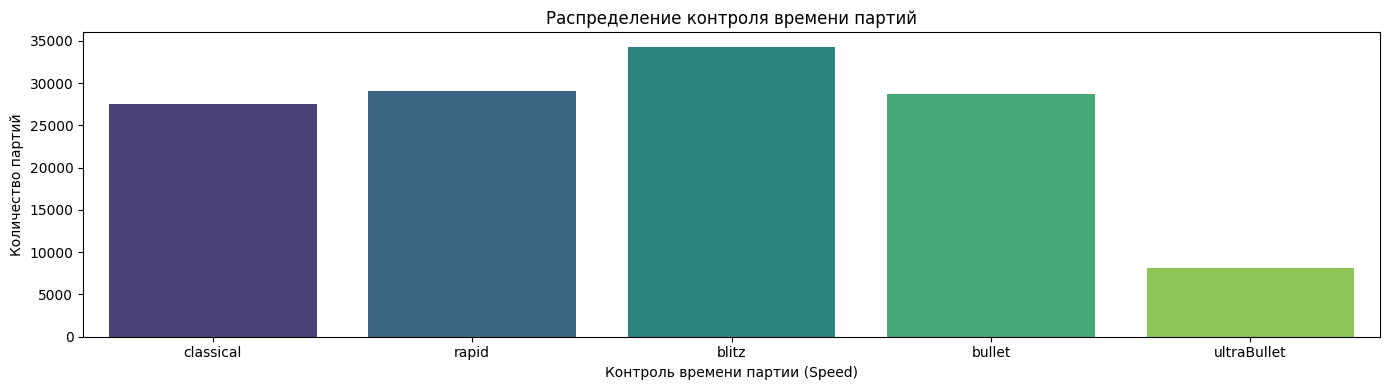

In [20]:
speed_order = ['classical', 'rapid', 'blitz', 'bullet', 'ultraBullet']
top_speeds['Speed'] = pd.Categorical(
    top_speeds['Speed'], categories=speed_order, ordered=True)

# Построение графика
plt.figure(figsize=(14, 4))
sns.barplot(
    data=top_speeds,
    x='Speed',
    y='Count',
    hue='Speed',
    palette='viridis',
    dodge=False,
    legend=False
)

plt.title('Распределение контроля времени партий')
plt.xlabel('Контроль времени партии (Speed)')
plt.ylabel('Количество партий')
plt.xticks(rotation=0, ha='center')
plt.grid(False)
plt.tight_layout()
plt.show()

classical - от 60 минут до нескольких часов.

rapid - от 10 до 60 минут.

blitz - от 3-х до 10 минут.

bullet - менее 3-х минут.

ultraBullet - менее 1-ой минуты.

#### Параметр `Source`

Source - источник партии (турнир, с другом, pool и т.д.) - категориальный

In [21]:
df['Source'].value_counts(dropna=False)

Source
pool      78518
lobby     23716
arena     16850
friend     6645
swiss      2071
api          31
Name: count, dtype: int64

Удалим игры через api, которые из-за нестандартного интерфейса для игрока могли повлиять на его уровень игры

In [22]:
df = df[df['Source'] != 'api'].reset_index(drop=True)

#### Параметр `Winner`

Winner - победитель партии (White, Black или None в случае ничьей) - категориальный

In [23]:
df['Winner'].value_counts(dropna=False, normalize=True)

Winner
white    0.473615
black    0.431049
NaN      0.095336
Name: proportion, dtype: float64

Заполним NA значения параметром draw

In [24]:
df['Winner'] = df['Winner'].fillna(value='draw')

Можно заметить, что в онлайн-шахматах доля побед значительно превышает долю ничьих, что не соответствует практическому опыту офлайн-шахмат.

#### Параметр `Game_Status`

Game_Status - статус завершения партии (ничья, мат, чит и т.д.) - категориальный

In [25]:
df['Game_Status'].value_counts(dropna=False)

Game_Status
resign       70637
outoftime    23142
mate         22103
draw         10392
timeout        775
stalemate      740
cheat           11
Name: count, dtype: int64

Удалим читерные партии из набора (cheat) и партии, где игроку засчитался проигрыш при отключении (timeout)

In [26]:
df = df[~df['Game_Status'].isin(['cheat', 'timeout'])].reset_index(drop=True)

#### Параметр `Opening_Name` и  `Opening_ECO`

Opening_Name - название дебюта, который был сыгран - категориальный

In [27]:
df['Opening_Name'].value_counts(dropna=False)

Opening_Name
Indian Defense                                                          1736
Sicilian Defense: Closed                                                1448
King's Indian Attack                                                    1187
Zukertort Opening                                                       1168
Modern Defense                                                          1076
                                                                        ... 
Italian Game: Giuoco Piano, Krause Variation                               1
Queen's Gambit Declined: Baltic Defense, Queen Attack Deferred             1
Queen's Indian Defense: Averbakh Variation                                 1
Italian Game: Two Knights Defense, Polerio Defense, Göring Variation       1
Benko Gambit: Fianchetto Variation                                         1
Name: count, Length: 2301, dtype: int64

Найдем самые популярные дебюты и их процент в общей доле.

In [28]:
opening_counts = df.groupby(
    ['Opening_ECO', 'Opening_Name']).size().reset_index(name='Count')

total_openings = opening_counts['Count'].sum()
opening_counts['Percentage'] = round(
    (opening_counts['Count'] / total_openings) * 100, 2)

opening_counts = opening_counts.sort_values(
    by='Count', ascending=False).reset_index(drop=True)
opening_counts

,Opening_ECO,Opening_Name,Count,Percentage
0,A45,Indian Defense,1736,1.37
1,B23,Sicilian Defense: Closed,1207,0.95
2,A04,Zukertort Opening: Kingside Fianchetto,1052,0.83
3,B06,Modern Defense,1044,0.82
4,D01,Rapport-Jobava System,958,0.75
...,...,...,...,...
2432,C31,King's Gambit Declined: Falkbeer Countergambit...,1,0.00
2433,D55,Queen's Gambit Declined: Pillsbury Attack,1,0.00
2434,A00,Barnes Opening: Gedult Gambit,1,0.00
2435,E92,King's Indian Defense: Orthodox Variation,1,0.00


Наиболее часто встречающиеся дебюты:

A00 - "неопределенные дебюты".

A04 - дебют известный как "Скандинавская защита", начинается с хода пешки на королевском фланге и стремится быстро развивать фигуры, чтобы контролировать центр. Этот дебют обычно выбирают игроки, которые хотят атаковать и не боятся рискованных позиций.

A45 - дебют, который называется "Защита Оуэна", начинается с хода пешкой на королевском фланге, но сосредоточен на более медленном и стратегическом раскрытии фигур. Игроки, использующие этот дебют, часто стремятся к созданию сложной позиции и могут играть на противостоянии сопернику, ожидая, когда тот сделает ошибку.

#### Параметр `Opening_PLY`

Opening_PLY - количество полуходов до выхода из дебютной стадии - числовой

In [29]:
# TODO: логика?

#### Параметр `Created_At`

Created_At - время создания партии - категориальный

In [30]:
# Создаем дополнительное поле - год игры
df['Created_Year'] = df['Created_At'].dt.to_period('Y')

year_counts = df.groupby('Created_Year').size()
year_counts

Created_Year
2014        1
2015       16
2016        7
2017      350
2018      524
2019      481
2020     1810
2021     3343
2022     4854
2023    14388
2024    73290
2025    27950
Freq: Y-DEC, dtype: int64

Удалим данные с 2014 по 2019 годы из-за малого числа наблюдений.

In [31]:
df = df[~df['Created_Year'].astype(
    str).isin(['2014', '2015', '2016', '2017', '2018', '2019'])].reset_index(drop=True)

Теперь посмотрим на распределение

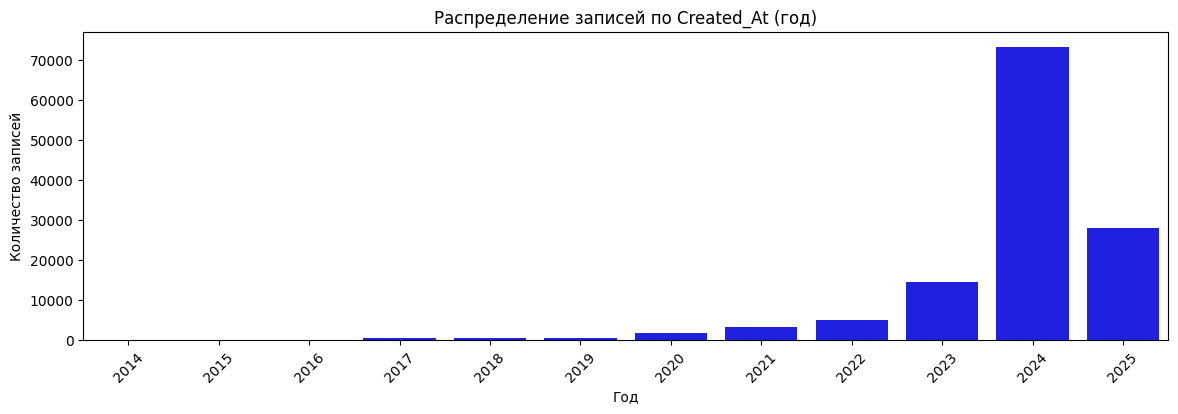

In [32]:
plt.figure(figsize=(14, 4))
sns.barplot(x=year_counts.index.astype(str),
            y=year_counts.values, color='blue')
plt.xticks(rotation=45)
plt.xlabel("Год")
plt.ylabel("Количество записей")
plt.title("Распределение записей по Created_At (год)")
plt.show()

Посмотрим на распределение игр по месяцам

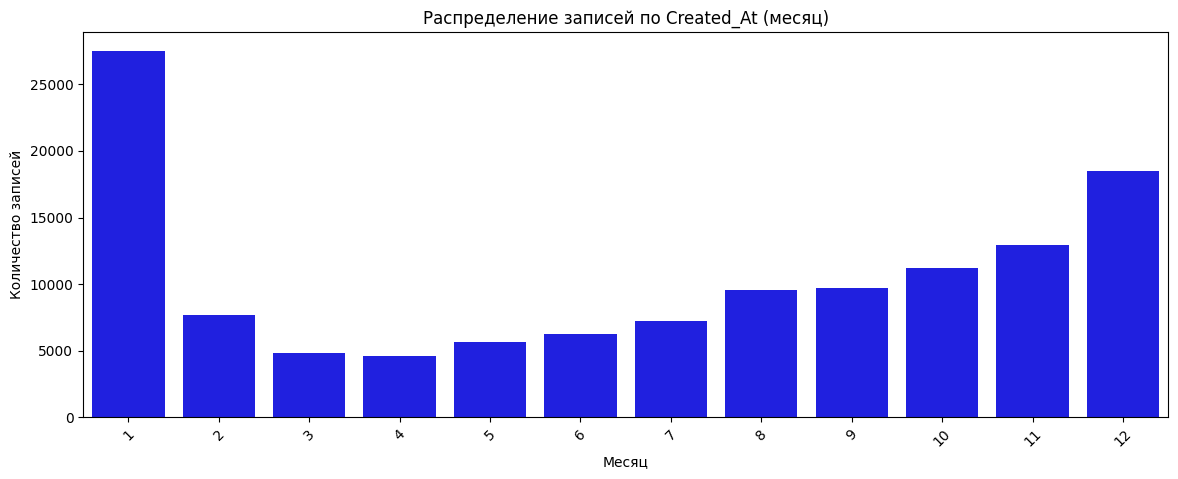

In [33]:
df['Created_Month'] = df['Created_At'].dt.month

month_counts = df.groupby('Created_Month').size()

plt.figure(figsize=(14, 5))
sns.barplot(x=month_counts.index.astype(str),
            y=month_counts.values, color='blue')
plt.xticks(rotation=45)
plt.xlabel("Месяц")
plt.ylabel("Количество записей")
plt.title("Распределение записей по Created_At (месяц)")
plt.show()

Чаще всего играют в январе и декабре. Можно выделить спад в весенне-летний период

Узнаем в какой день недели чаще всего играют в шахматы

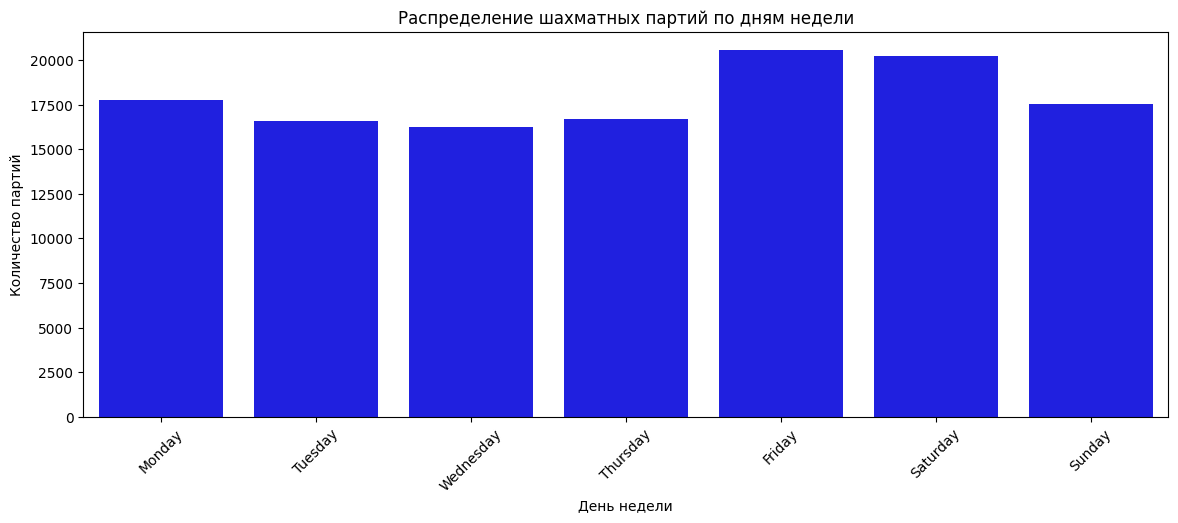

In [34]:
df["weekday"] = df["Created_At"].dt.day_name()
ordered_days = ["Monday", "Tuesday", "Wednesday",
                "Thursday", "Friday", "Saturday", "Sunday"]

day_counts = df["weekday"].value_counts().reindex(ordered_days)


plt.figure(figsize=(14, 5))
sns.barplot(x=day_counts.index, y=day_counts.values,  color='blue')
plt.title("Распределение шахматных партий по дням недели")
plt.xlabel("День недели")
plt.ylabel("Количество партий")
plt.xticks(rotation=45)
plt.show()

По пятницам и субботам в шахматы играют чаще всего

Узнаем в какой время суток чаще всего играют в шахматы

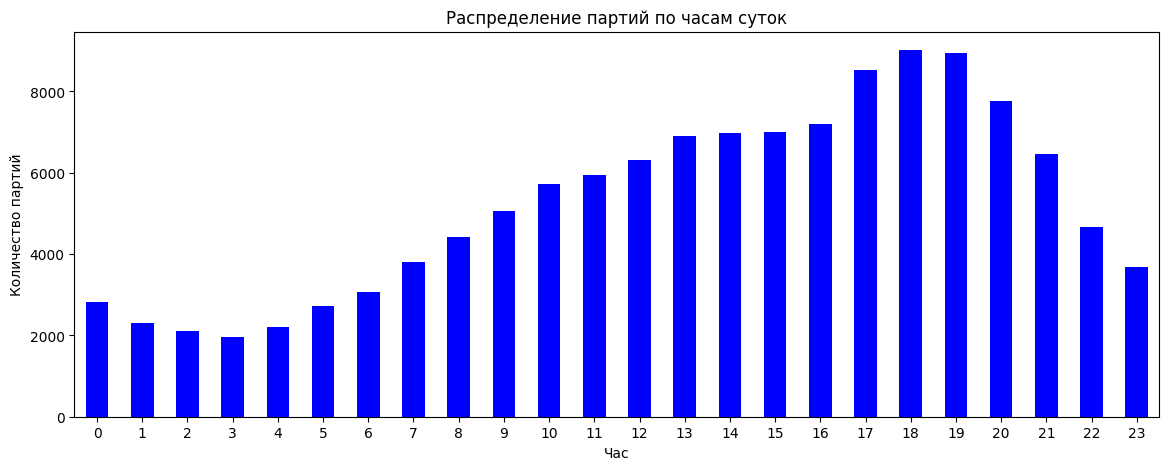

In [35]:
df["Hour"] = df["Created_At"].dt.hour
df["Hour"].value_counts().sort_index().plot(
    kind="bar", figsize=(14, 5), color='blue')
plt.title("Распределение партий по часам суток")
plt.xlabel("Час")
plt.ylabel("Количество партий")
plt.xticks(rotation=0)
plt.show()

Чаще всего люди играют в вечернее время (с 17 до 20 UTC)

#### Параметр `Last_Move_At`

Last_Move_At - время последнего хода в партии - категориальный

In [36]:
# Создаем дополнительное поле - год игры
df['Last_Move_Year'] = df['Last_Move_At'].dt.to_period('Y')

last_move_year_counts = df.groupby('Last_Move_Year').size()
last_move_year_counts

Last_Move_Year
2020     1810
2021     3343
2022     4854
2023    14386
2024    73291
2025    27951
Freq: Y-DEC, dtype: int64

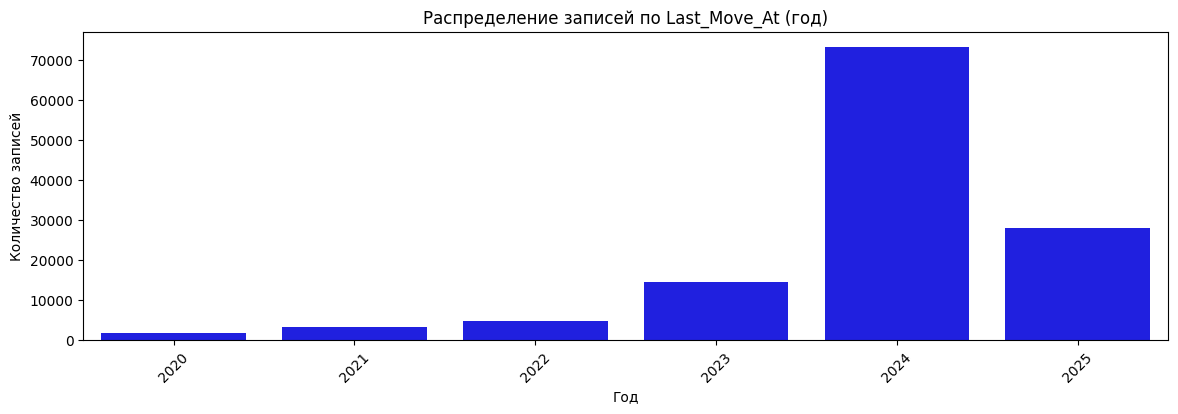

In [37]:
plt.figure(figsize=(14, 4))
sns.barplot(x=last_move_year_counts.index.astype(str),
            y=last_move_year_counts.values, color='blue')
plt.xticks(rotation=45)
plt.xlabel("Год")
plt.ylabel("Количество записей")
plt.title("Распределение записей по Last_Move_At (год)")
plt.show()

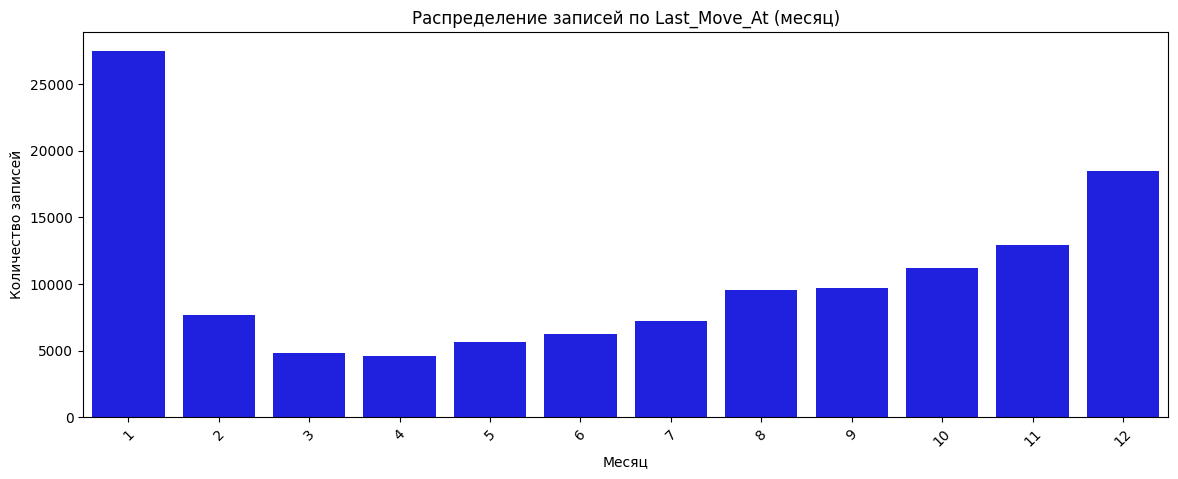

In [38]:
df['Last_Move_Month'] = df['Last_Move_At'].dt.month

last_move_month_counts = df.groupby('Last_Move_Month').size()

plt.figure(figsize=(14, 5))
sns.barplot(x=last_move_month_counts.index.astype(str),
            y=last_move_month_counts.values, color='blue')
plt.xticks(rotation=45)
plt.xlabel("Месяц")
plt.ylabel("Количество записей")
plt.title("Распределение записей по Last_Move_At (месяц)")
plt.show()

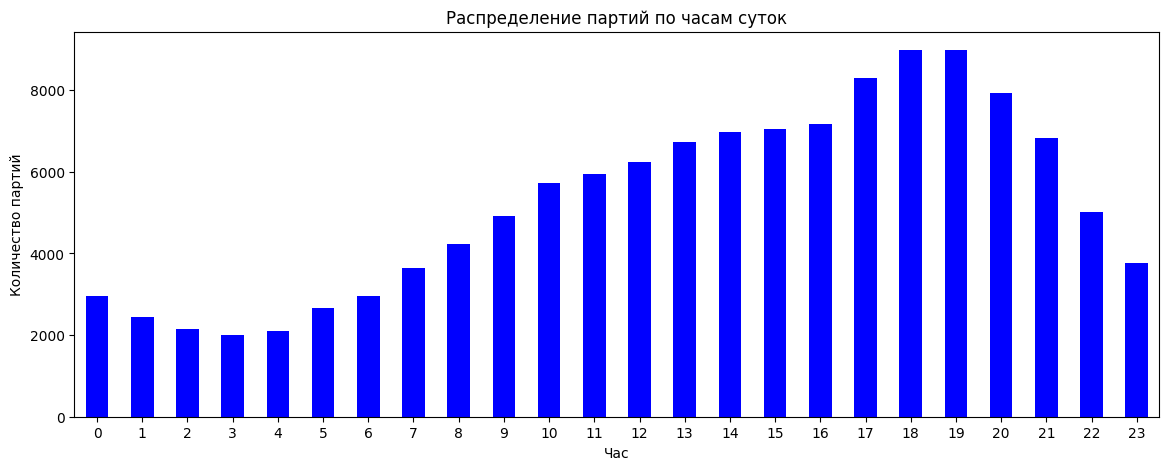

In [39]:
df["Last_Move_Hour"] = df["Last_Move_At"].dt.hour
df["Last_Move_Hour"].value_counts().sort_index().plot(
    kind="bar", figsize=(14, 5), color='blue')
plt.title("Распределение партий по часам суток")
plt.xlabel("Час")
plt.ylabel("Количество партий")
plt.xticks(rotation=0)
plt.show()

Данный параметр имеет то же распределение, что и `Created_At`

#### Параметр `White_Player` и `Black_Player`

White_Player и Black_Player - идентификатор игрока, игравшего белыми и черными фигурами - категориальный

Посмотрим на игроков, которые чаще всего играют и какими фигурами

In [40]:
white_cnt = df['White_Player'].value_counts()
black_cnt = df['Black_Player'].value_counts()

total_games = white_cnt.add(black_cnt, fill_value=0).astype(int)

top10_players = total_games.nlargest(10, keep='all')

white_color_counts = df['White_Player'].value_counts()
black_color_counts = df['Black_Player'].value_counts()

top10_df = pd.DataFrame({
    'Total_Games': top10_players,
    'As_White': white_color_counts[top10_players.index].fillna(0).astype(int),
    'As_Black': black_color_counts[top10_players.index].fillna(0).astype(int)
})

top10_df['Preferred_Color'] = top10_df[['As_White', 'As_Black']].idxmax(axis=1)
top10_df

,Total_Games,As_White,As_Black,Preferred_Color
zhigalko_sergei,791,402,389,As_White
andrey11976,783,394,389,As_White
dmitrijiiigm,738,366,372,As_Black
tuzakli_egitim,696,376,320,As_White
rebeccaharris,654,332,322,As_White
ediz_gurel,643,306,337,As_Black
ilqar_7474,632,355,277,As_White
maybe_maybe,631,302,329,As_Black
anonymousblitz,626,308,318,As_Black
littleplotkin,625,307,318,As_Black


#### Параметр `White_Title` и `Black_Title`

White_Title - шахматный титул игрока, игравшего белыми (например, GM, IM, FM) - категориальный

In [41]:
df['White_Title'].value_counts(dropna=False)

White_Title
NaN    84688
GM     15640
IM     10152
FM     10056
CM      2789
NM      2207
LM        42
WFM       23
WIM       15
WCM       12
BOT       10
WGM        1
Name: count, dtype: int64

In [42]:
df['Black_Title'].value_counts(dropna=False)

Black_Title
NaN    84684
GM     15473
FM     10225
IM     10182
CM      2692
NM      2262
LM        43
WFM       35
WIM       16
WCM       11
BOT        8
WGM        4
Name: count, dtype: int64

Заполним пропуски значением NT - No Title

In [43]:
df['White_Title'] = df['White_Title'].fillna('NT')
df['Black_Title'] = df['Black_Title'].fillna('NT')

#### Параметр `White_Rating`

White_Rating - рейтинг белого игрока - числовой

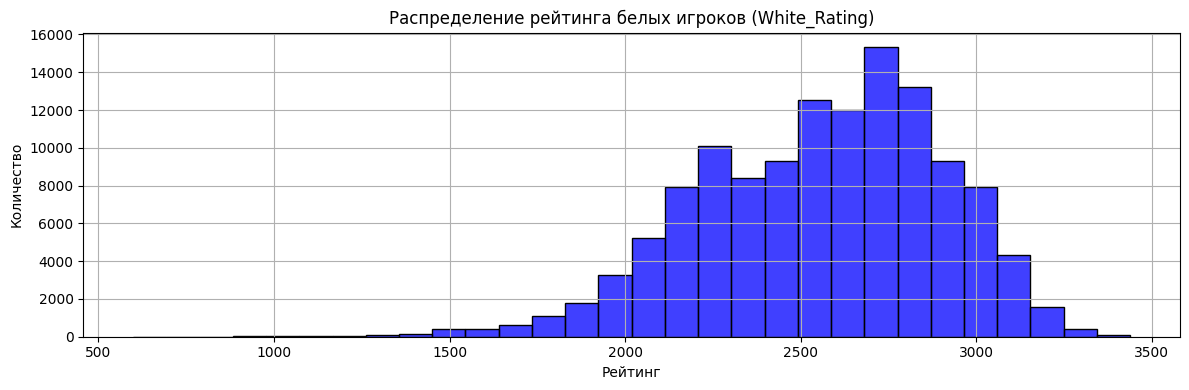

In [44]:
plt.figure(figsize=(12, 4))
sns.histplot(data=df, x='White_Rating', bins=30, color='blue')

plt.title('Распределение рейтинга белых игроков (White_Rating)')
plt.xlabel('Рейтинг')
plt.ylabel('Количество')
plt.grid(True)
plt.tight_layout()
plt.show()

Избавимся от выбросов

In [45]:
Q1_white_rating = df['White_Rating'].quantile(0.25)
Q3_white_rating = df['White_Rating'].quantile(0.75)
IQR_white_rating = Q3_white_rating - Q1_white_rating

lower_bound_white_rating = Q1_white_rating - 1.5 * IQR_white_rating
upper_bound_white_rating = Q3_white_rating + 1.5 * IQR_white_rating

df = df[(df['White_Rating'] >= lower_bound_white_rating) &
                              (df['White_Rating'] <= upper_bound_white_rating)].reset_index(drop=True)

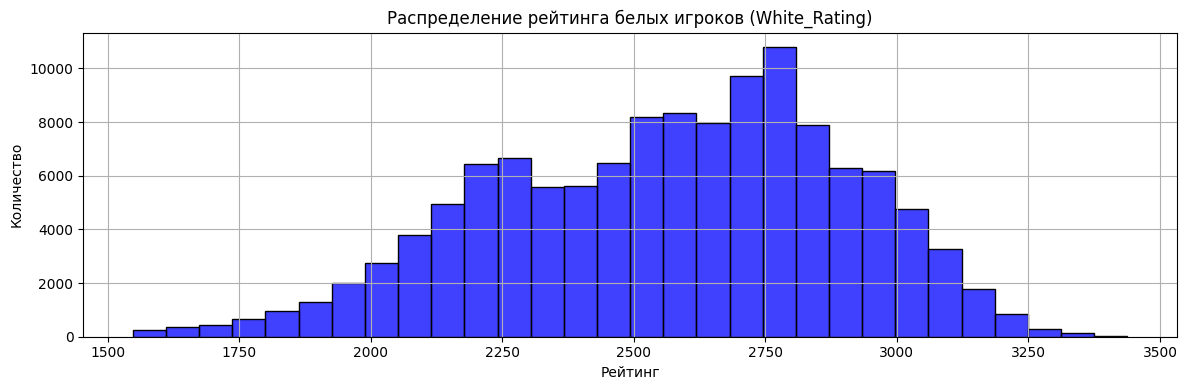

In [46]:
plt.figure(figsize=(12, 4))
sns.histplot(data=df, x='White_Rating', bins=30, color='blue')

plt.title('Распределение рейтинга белых игроков (White_Rating)')
plt.xlabel('Рейтинг')
plt.ylabel('Количество')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Параметр `Black_Rating`

Black_Rating - рейтинг черного игрока - числовой

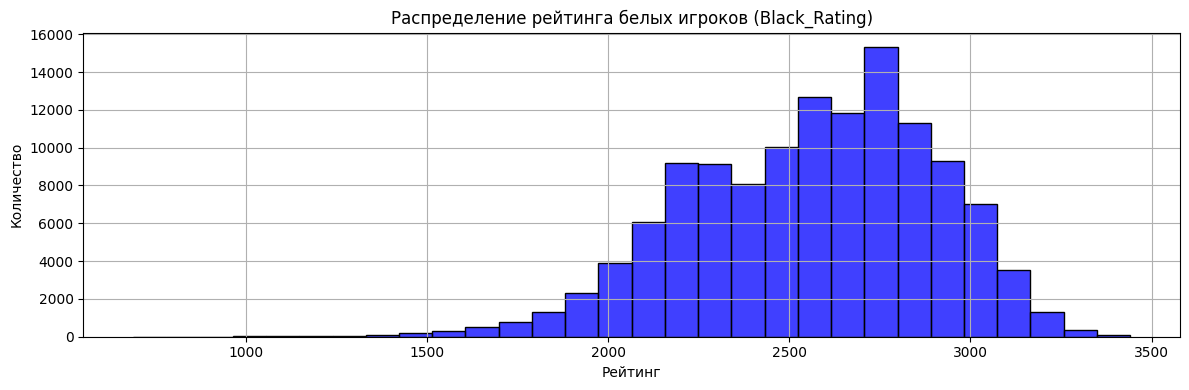

In [47]:
plt.figure(figsize=(12, 4))
sns.histplot(data=df, x='Black_Rating', bins=30, color='blue')

plt.title('Распределение рейтинга белых игроков (Black_Rating)')
plt.xlabel('Рейтинг')
plt.ylabel('Количество')
plt.grid(True)
plt.tight_layout()
plt.show()

Избавимся от выбросов

In [48]:
Q1_black_rating = df['Black_Rating'].quantile(0.25)
Q3_black_rating = df['Black_Rating'].quantile(0.75)
IQR_black_rating = Q3_black_rating - Q1_black_rating

lower_bound_black_rating = Q1_black_rating - 1.5 * IQR_black_rating
upper_bound_black_rating = Q3_black_rating + 1.5 * IQR_black_rating

df = df[(df['Black_Rating'] >= lower_bound_black_rating) &
                              (df['Black_Rating'] <= upper_bound_black_rating)].reset_index(drop=True)

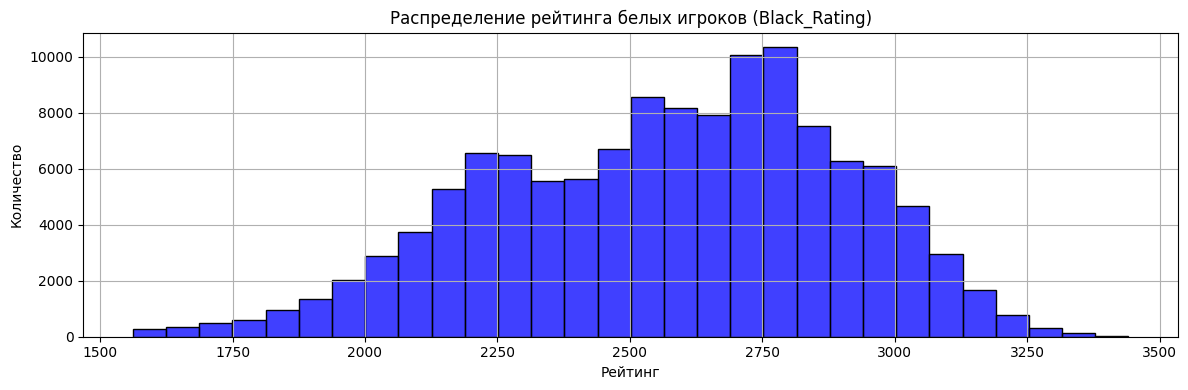

In [49]:
plt.figure(figsize=(12, 4))
sns.histplot(data=df, x='Black_Rating', bins=30, color='blue')

plt.title('Распределение рейтинга белых игроков (Black_Rating)')
plt.xlabel('Рейтинг')
plt.ylabel('Количество')
plt.grid(True)
plt.tight_layout()
plt.show()

In [50]:
# TODO: что с этим полем?

#### Параметр `White_Inaccuracy` и `Black_Inaccuracy`

White_Inaccuracy и Black_Inaccuracy - количество неточностей, допущенных игроком белыми и черными фигурами - числовой

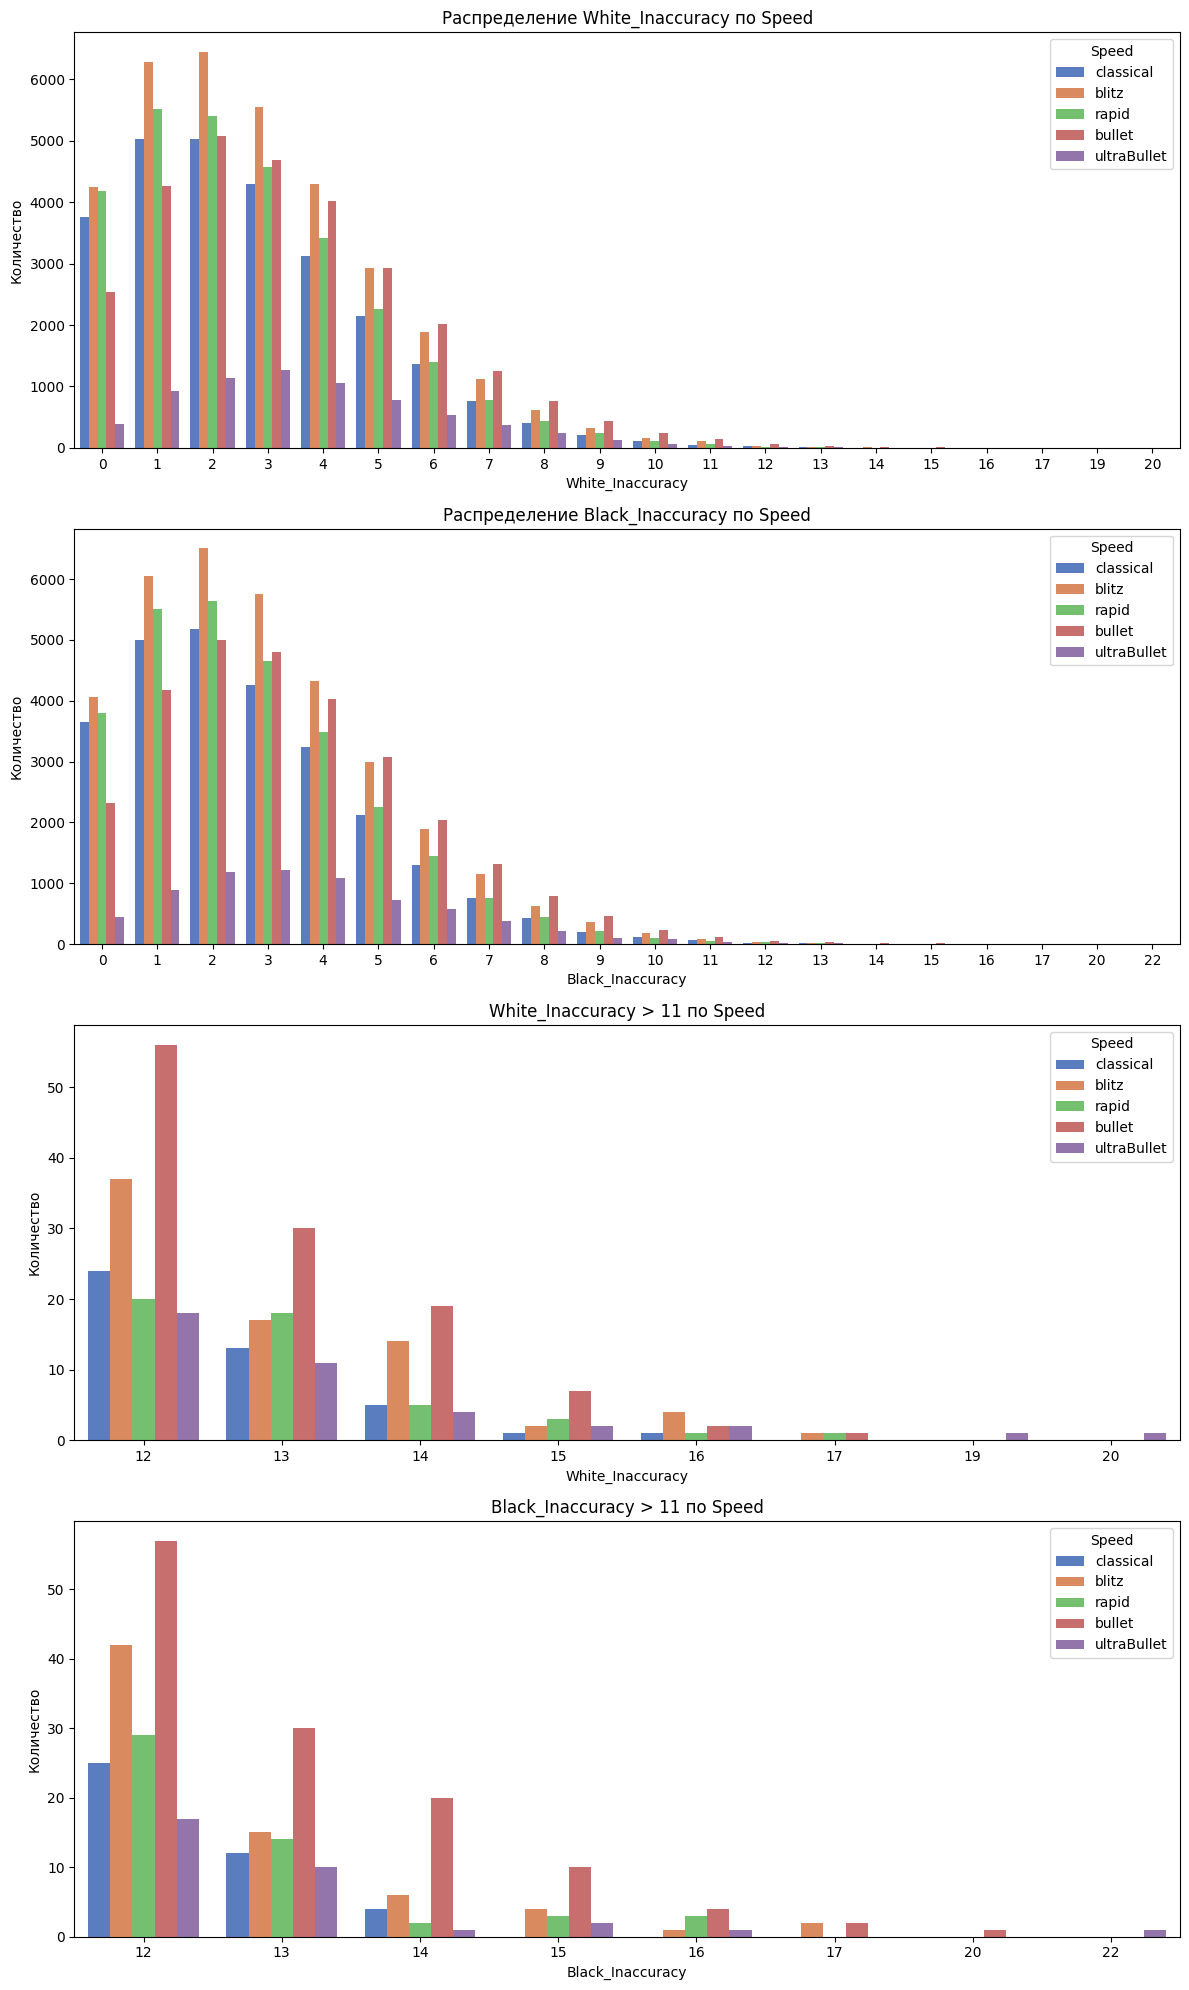

In [51]:
fig, axes = plt.subplots(4, 1, figsize=(12, 20))

sns.countplot(data=df, x='White_Inaccuracy',
              hue='Speed', palette='muted', ax=axes[0])
axes[0].set_title('Распределение White_Inaccuracy по Speed')
axes[0].set_xlabel('White_Inaccuracy')
axes[0].set_ylabel('Количество')
axes[0].grid(False)

sns.countplot(data=df, x='Black_Inaccuracy',
              hue='Speed', palette='muted', ax=axes[1])
axes[1].set_title('Распределение Black_Inaccuracy по Speed')
axes[1].set_xlabel('Black_Inaccuracy')
axes[1].set_ylabel('Количество')
axes[1].grid(False)

sns.countplot(data=df[df['White_Inaccuracy'] > 11],
              x='White_Inaccuracy', hue='Speed', palette='muted', ax=axes[2])
axes[2].set_title('White_Inaccuracy > 11 по Speed')
axes[2].set_xlabel('White_Inaccuracy')
axes[2].set_ylabel('Количество')
axes[2].grid(False)

sns.countplot(data=df[df['Black_Inaccuracy'] > 11],
              x='Black_Inaccuracy', hue='Speed', palette='muted', ax=axes[3])
axes[3].set_title('Black_Inaccuracy > 11 по Speed')
axes[3].set_xlabel('Black_Inaccuracy')
axes[3].set_ylabel('Количество')
axes[3].grid(False)

plt.tight_layout()
plt.show()

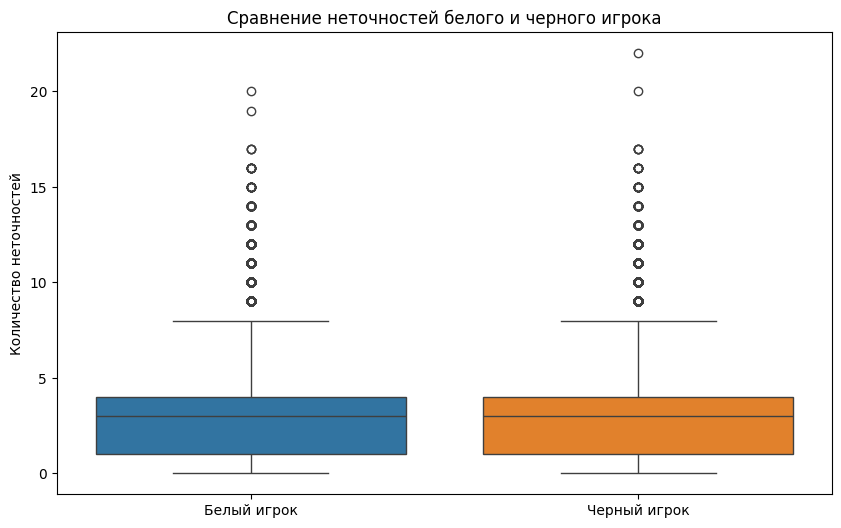

In [52]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[['White_Inaccuracy', 'Black_Inaccuracy']])
plt.title('Сравнение неточностей белого и черного игрока')
plt.ylabel('Количество неточностей')
plt.xticks([0, 1], ['Белый игрок', 'Черный игрок'])
plt.show()

In [53]:
quantiles_white_inaccuracy = df.groupby('Speed')['White_Mistake'].quantile(
    [0.25, 0.5, 0.75, 0.9]).unstack().reset_index()
quantiles_white_inaccuracy.columns = [
    'Speed', 'White_Q25', 'White_Q50', 'White_Q75', 'White_Q90']

quantiles_black_inaccuracy = df.groupby('Speed')['Black_Mistake'].quantile(
    [0.25, 0.5, 0.75, 0.9]).unstack().reset_index()
quantiles_black_inaccuracy.columns = [
    'Speed', 'Black_Q25', 'Black_Q50', 'Black_Q75', 'Black_Q90'
]

quantiles_mistakes = pd.merge(
    quantiles_white_inaccuracy, quantiles_black_inaccuracy, on='Speed')
quantiles_mistakes

,Speed,White_Q25,White_Q50,White_Q75,White_Q90,Black_Q25,Black_Q50,Black_Q75,Black_Q90
0,blitz,0.0,1.0,2.0,3.0,0.0,1.0,2.0,3.0
1,bullet,0.0,1.0,2.0,3.0,0.0,1.0,2.0,3.0
2,classical,0.0,1.0,2.0,3.0,0.0,1.0,2.0,3.0
3,rapid,0.0,1.0,2.0,3.0,0.0,1.0,2.0,3.0
4,ultraBullet,1.0,1.0,3.0,4.0,1.0,1.0,3.0,4.0


In [54]:
# TODO: что с этим полем?


#### Параметр `White_Mistake` и `Black_Mistake`

White_Mistake и Black_Mistake - количество ошибок, допущенных игроком белыми и черными - числовой

Построим распределение ошибок за белых и черных по типу временного контроля

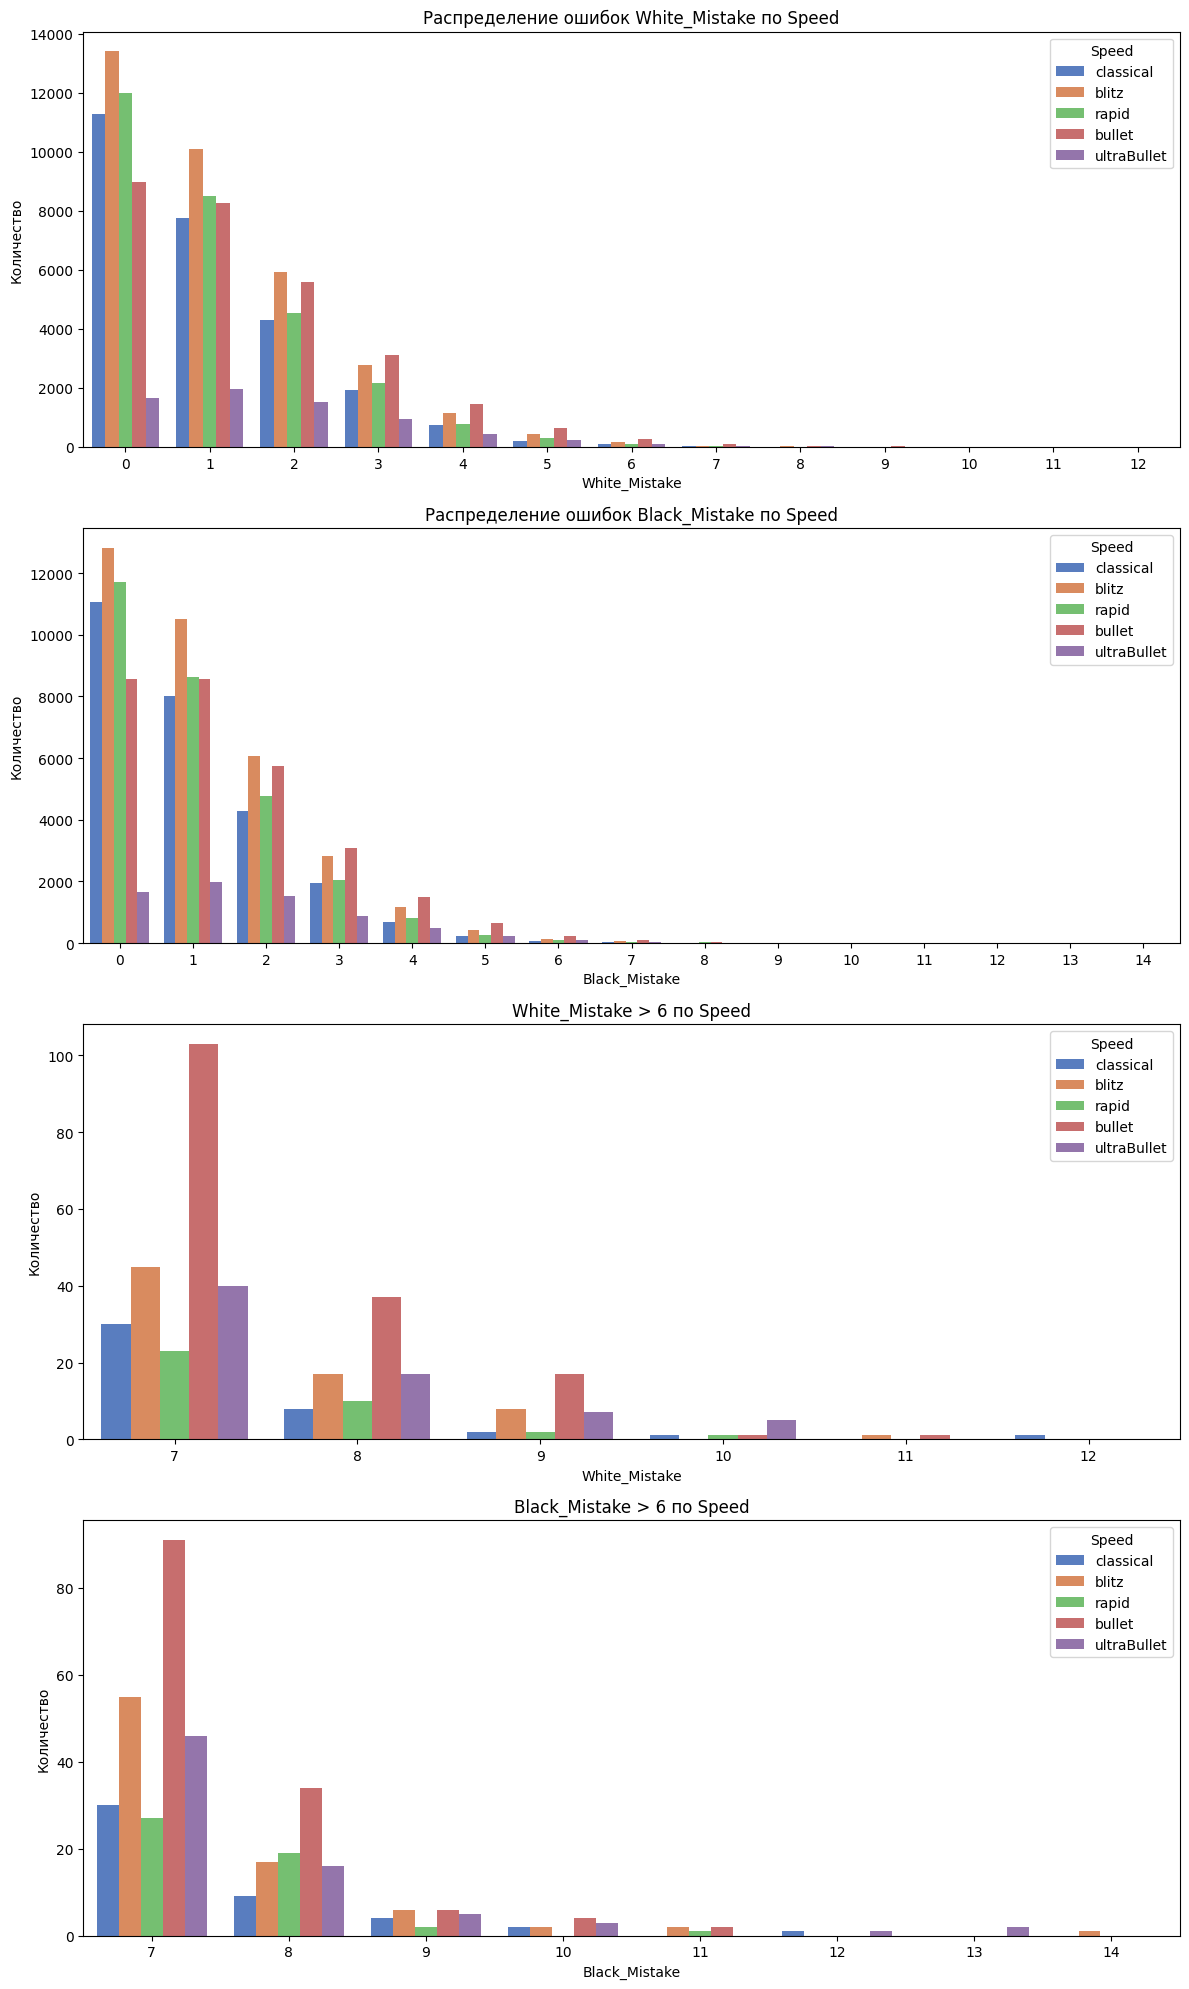

In [55]:
fig, axes = plt.subplots(4, 1, figsize=(12, 20))

sns.countplot(data=df, x='White_Mistake', hue='Speed',
              palette='muted', ax=axes[0])
axes[0].set_title('Распределение ошибок White_Mistake по Speed')
axes[0].set_xlabel('White_Mistake')
axes[0].set_ylabel('Количество')
axes[0].grid(False)

sns.countplot(data=df, x='Black_Mistake', hue='Speed',
              palette='muted', ax=axes[1])
axes[1].set_title('Распределение ошибок Black_Mistake по Speed')
axes[1].set_xlabel('Black_Mistake')
axes[1].set_ylabel('Количество')
axes[1].grid(False)

sns.countplot(data=df[df['White_Mistake'] > 6],
              x='White_Mistake', hue='Speed', palette='muted', ax=axes[2])
axes[2].set_title('White_Mistake > 6 по Speed')
axes[2].set_xlabel('White_Mistake')
axes[2].set_ylabel('Количество')
axes[2].grid(False)

sns.countplot(data=df[df['Black_Mistake'] > 6],
              x='Black_Mistake', hue='Speed', palette='muted', ax=axes[3])
axes[3].set_title('Black_Mistake > 6 по Speed')
axes[3].set_xlabel('Black_Mistake')
axes[3].set_ylabel('Количество')
axes[3].grid(False)

plt.tight_layout()
plt.show()

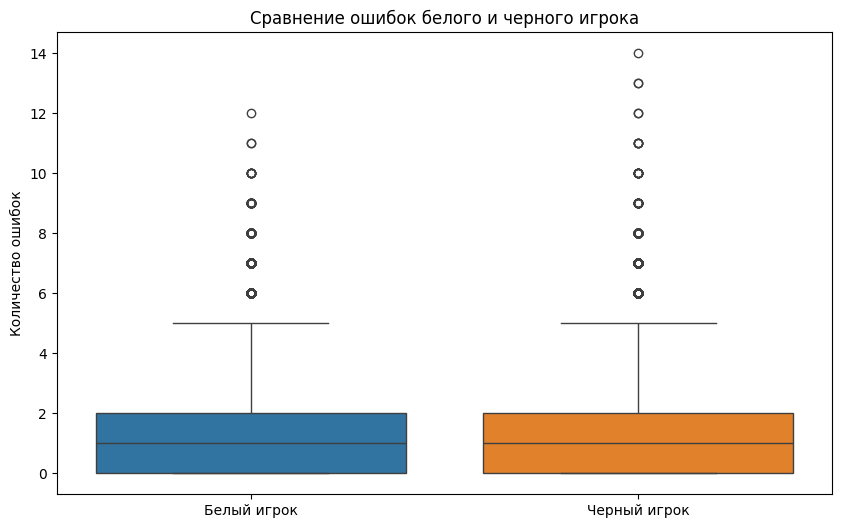

In [56]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[['White_Mistake', 'Black_Mistake']])
plt.title('Сравнение ошибок белого и черного игрока')
plt.ylabel('Количество ошибок')
plt.xticks([0, 1], ['Белый игрок', 'Черный игрок'])
plt.show()

Удалим выбросы

In [57]:
Q1_White_Mistake = df['White_Mistake'].quantile(0.25)
Q3_White_Mistake = df['White_Mistake'].quantile(0.75)

IQR_White_Mistake = Q3_White_Mistake - Q1_White_Mistake

lower_bound_white_mistake = Q1_White_Mistake - 1.5 * IQR_White_Mistake
upper_bound_white_mistake = Q3_White_Mistake + 1.5 * IQR_White_Mistake

Q1_Black_Mistake = df['Black_Mistake'].quantile(0.25)
Q3_Black_Mistake = df['Black_Mistake'].quantile(0.75)

IQR_Black_Mistake = Q3_Black_Mistake - Q1_Black_Mistake
lower_bound_black_mistake = Q1_Black_Mistake - 1.5 * IQR_Black_Mistake
upper_bound_black_mistake = Q3_Black_Mistake + 1.5 * IQR_Black_Mistake

df = df[(df['White_Mistake'] >= lower_bound_white_mistake) &
        (df['White_Mistake'] <= upper_bound_white_mistake)].reset_index(drop=True)

df = df[(df['Black_Mistake'] >= lower_bound_black_mistake) &
        (df['Black_Mistake'] <= upper_bound_black_mistake)].reset_index(drop=True)

In [58]:
quantiles_white_mistake = df.groupby('Speed')['White_Mistake'].quantile(
    [0.25, 0.5, 0.75, 0.9]).unstack().reset_index()
quantiles_white_mistake.columns = [
    'Speed', 'White_Q25', 'White_Q50', 'White_Q75', 'White_Q90']

quantiles_black_mistake = df.groupby('Speed')['Black_Mistake'].quantile(
    [0.25, 0.5, 0.75, 0.9]).unstack().reset_index()
quantiles_black_mistake.columns = [
    'Speed', 'Black_Q25', 'Black_Q50', 'Black_Q75', 'Black_Q90'
]

quantiles_mistakes = pd.merge(
    quantiles_white_mistake, quantiles_black_mistake, on='Speed')
quantiles_mistakes

,Speed,White_Q25,White_Q50,White_Q75,White_Q90,Black_Q25,Black_Q50,Black_Q75,Black_Q90
0,blitz,0.0,1.0,2.0,3.0,0.0,1.0,2.0,3.0
1,bullet,0.0,1.0,2.0,3.0,0.0,1.0,2.0,3.0
2,classical,0.0,1.0,2.0,3.0,0.0,1.0,2.0,3.0
3,rapid,0.0,1.0,2.0,3.0,0.0,1.0,2.0,3.0
4,ultraBullet,0.0,1.0,2.0,3.0,1.0,1.0,2.0,3.0


In [59]:
# TODO: Добавить вывод

#### Параметр `White_Blunder` и `Black_Blunder`

White_Blunder и Black_Blunder - количество грубых ошибок (зевков), допущенных игроком белыми и черными - числовой

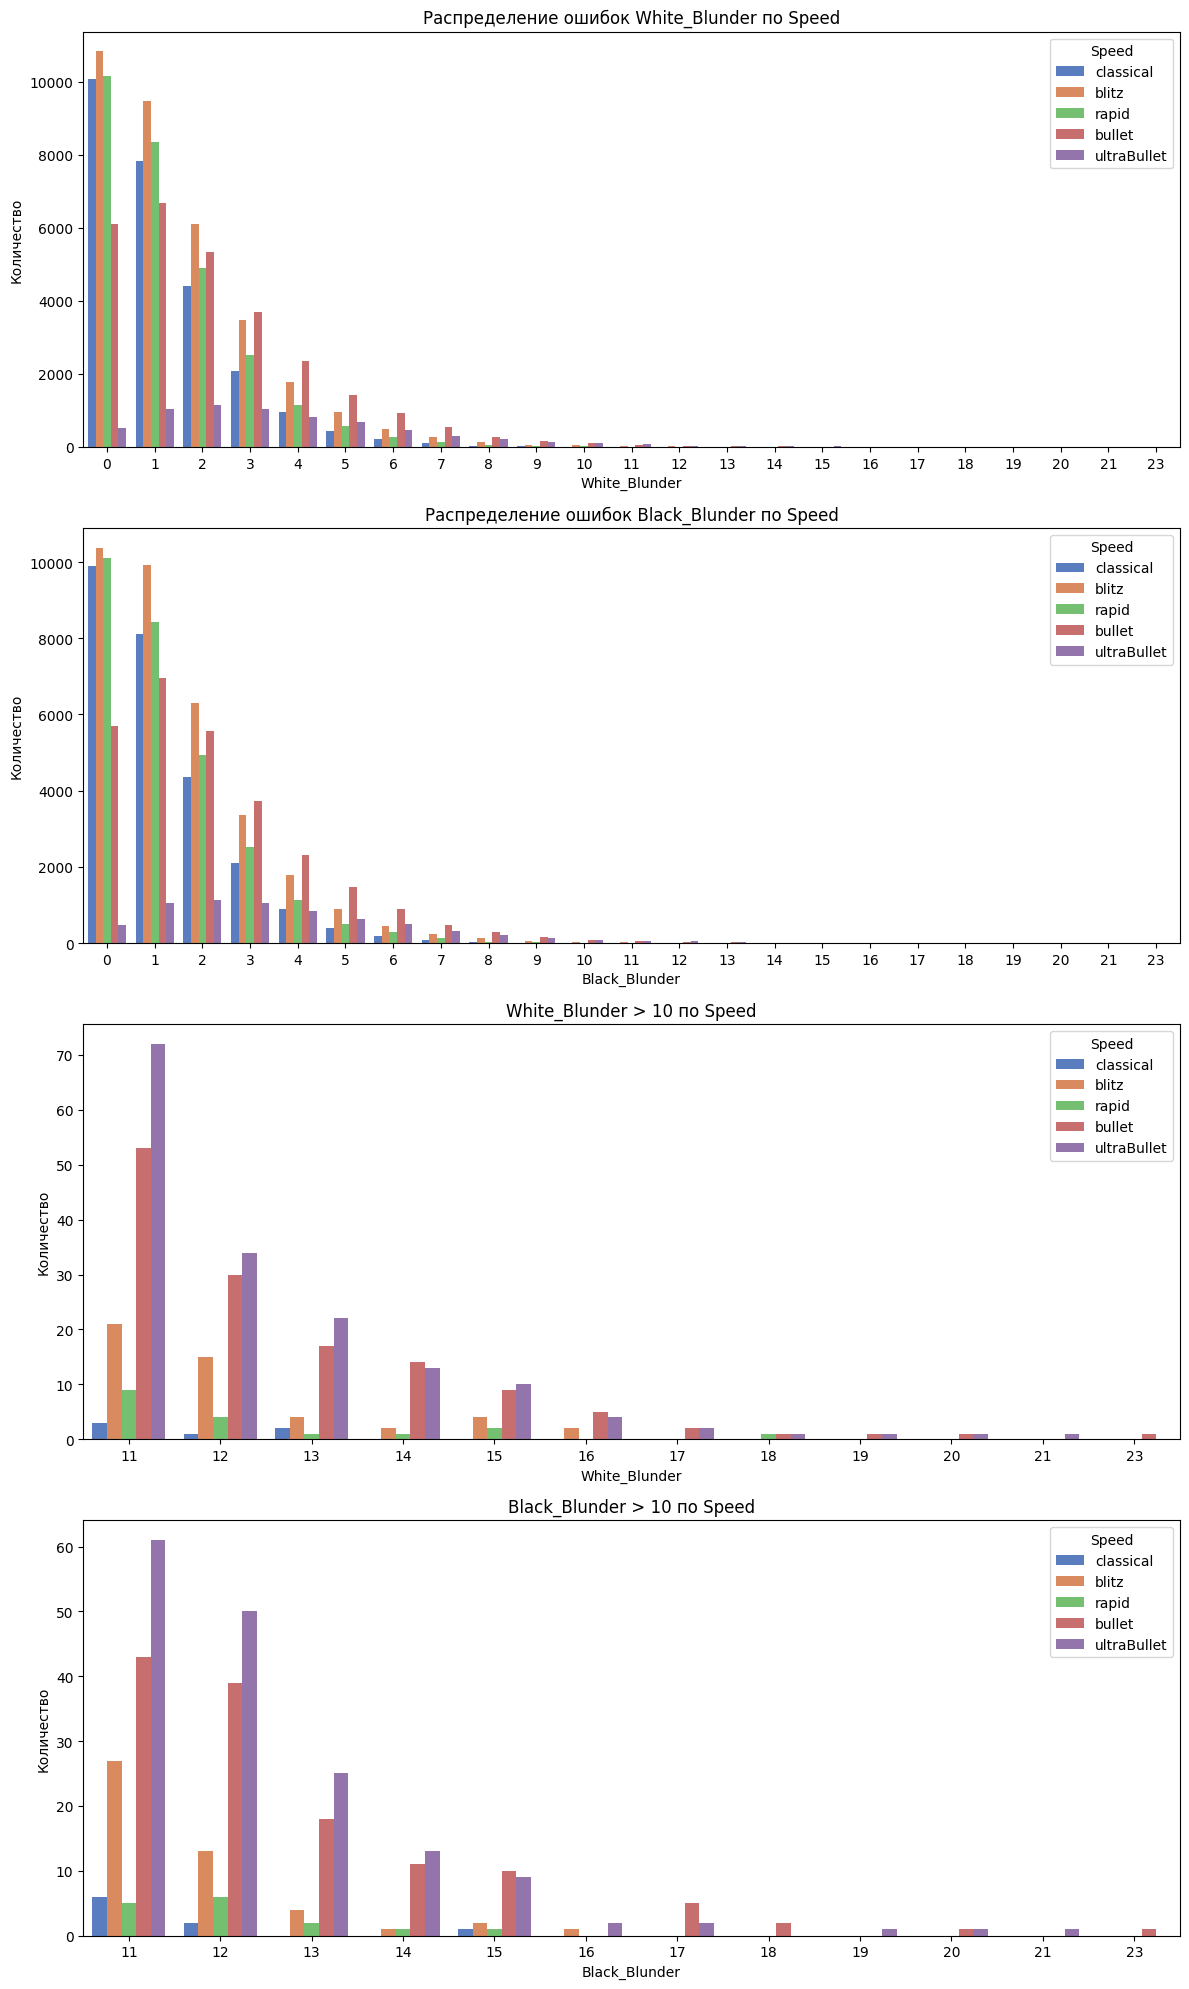

In [60]:
fig, axes = plt.subplots(4, 1, figsize=(12, 20))

sns.countplot(data=df, x='White_Blunder', hue='Speed',
              palette='muted', ax=axes[0])
axes[0].set_title('Распределение ошибок White_Blunder по Speed')
axes[0].set_xlabel('White_Blunder')
axes[0].set_ylabel('Количество')
axes[0].grid(False)

sns.countplot(data=df, x='Black_Blunder', hue='Speed',
              palette='muted', ax=axes[1])
axes[1].set_title('Распределение ошибок Black_Blunder по Speed')
axes[1].set_xlabel('Black_Blunder')
axes[1].set_ylabel('Количество')
axes[1].grid(False)

sns.countplot(data=df[df['White_Blunder'] > 10],
              x='White_Blunder', hue='Speed', palette='muted', ax=axes[2])
axes[2].set_title('White_Blunder > 10 по Speed')
axes[2].set_xlabel('White_Blunder')
axes[2].set_ylabel('Количество')
axes[2].grid(False)

sns.countplot(data=df[df['Black_Blunder'] > 10],
              x='Black_Blunder', hue='Speed', palette='muted', ax=axes[3])
axes[3].set_title('Black_Blunder > 10 по Speed')
axes[3].set_xlabel('Black_Blunder')
axes[3].set_ylabel('Количество')
axes[3].grid(False)

plt.tight_layout()
plt.show()

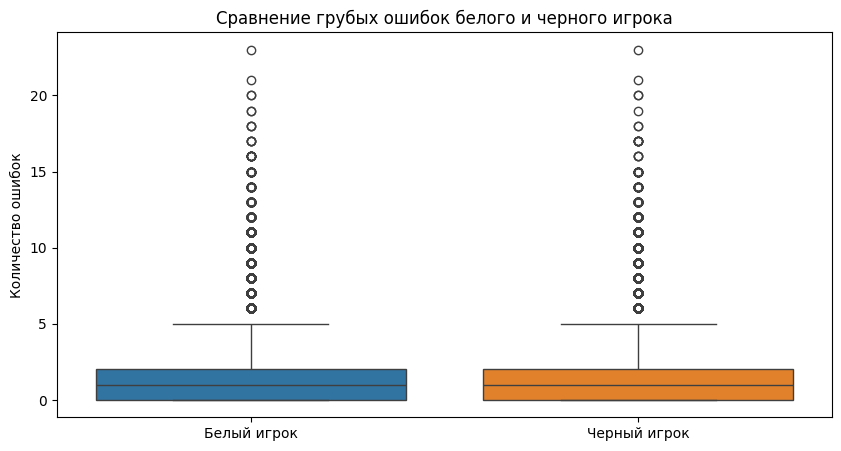

In [61]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df[['White_Blunder', 'Black_Blunder']])
plt.title('Сравнение грубых ошибок белого и черного игрока')
plt.ylabel('Количество ошибок')
plt.xticks([0, 1], ['Белый игрок', 'Черный игрок'])
plt.show()

Удалим выбросы

In [62]:
Q1_White_Blunder = df['White_Blunder'].quantile(0.25)
Q3_White_Blunder = df['White_Blunder'].quantile(0.75)
IQR_White_Blunder = Q3_White_Blunder - Q1_White_Blunder

lower_bound_white_blunder = Q1_White_Blunder - 1.5 * IQR_White_Blunder
upper_bound_white_blunder = Q3_White_Blunder + 1.5 * IQR_White_Blunder

Q1_Black_Blunder = df['Black_Blunder'].quantile(0.25)
Q3_Black_Blunder = df['Black_Blunder'].quantile(0.75)
IQR_Black_Blunder = Q3_Black_Blunder - Q1_Black_Blunder

lower_bound_black_blunder = Q1_Black_Blunder - 1.5 * IQR_Black_Blunder
upper_bound_black_blunder = Q3_Black_Blunder + 1.5 * IQR_Black_Blunder

df = df[(df['White_Blunder'] >= lower_bound_white_blunder) & (
    df['White_Blunder'] <= upper_bound_white_blunder)].reset_index(drop=True)
df = df[(df['Black_Blunder'] >= lower_bound_black_blunder) & (
    df['Black_Blunder'] <= upper_bound_black_blunder)].reset_index(drop=True)

Узнаем количество партий и долю, сыгранных без ошибок для белых и черных игроков

In [63]:
total_games = df.shape[0]

no_errors_white = df.query("White_Mistake == 0 and White_Blunder == 0")
no_errors_black = df.query("Black_Mistake == 0 and Black_Blunder == 0")

count_no_errors_white = no_errors_white.shape[0]
count_no_errors_black = no_errors_black.shape[0]

percentage_no_errors_white = (count_no_errors_white / total_games) * 100
percentage_no_errors_black = (count_no_errors_black / total_games) * 100

print(
    f"Количество партий без ошибок у белых: {count_no_errors_white} ({percentage_no_errors_white:.2f}%)")
print(
    f"Количество партий без ошибок у черных: {count_no_errors_black} ({percentage_no_errors_black:.2f}%)")

Количество партий без ошибок у белых: 20991 (18.26%)
Количество партий без ошибок у черных: 19006 (16.53%)


Узнаем были ли такие партиии, где ни белые, ни черные не совершили ни одной ошибки.

In [64]:
no_errors_white_and_black = df.query("White_Mistake == 0 and White_Blunder == 0 and Black_Mistake == 0 and Black_Blunder == 0")

count_no_errors_white_and_black = no_errors_white_and_black.shape[0]

# Вычисление процента безошибочных партий у белых и черных одновременно
percentage_no_errors_white_and_black = (count_no_errors_white_and_black / total_games) * 100

print(f"Количество партий, где ни белые, ни черные не совершили ни одной ошибки.: {count_no_errors_white_and_black}")
print(f"Процент партий, где ни белые, ни черные не совершили ни одной ошибки: {percentage_no_errors_white_and_black:.2f}%")

Количество партий, где ни белые, ни черные не совершили ни одной ошибки.: 4150
Процент партий, где ни белые, ни черные не совершили ни одной ошибки: 3.61%


Вычислим процентили зевков для каждого контроля времени партии (Speed)

In [65]:
quantiles_white_blunders = df.groupby('Speed')['White_Blunder'].quantile(
    [0.25, 0.5, 0.75, 0.9]).unstack().reset_index()
quantiles_white_blunders.columns = ['Speed', 'White_Q25',
                           'White_Q50', 'White_Q75', 'White_Q90']

quantiles_black_blunders = df.groupby('Speed')['Black_Blunder'].quantile(
    [0.25, 0.5, 0.75, 0.9]).unstack().reset_index()
quantiles_black_blunders.columns = ['Speed', 'Black_Q25',
                           'Black_Q50', 'Black_Q75', 'Black_Q90']

quantiles_blunders = pd.merge(quantiles_white_blunders, quantiles_black_blunders, on='Speed')
quantiles_blunders

,Speed,White_Q25,White_Q50,White_Q75,White_Q90,Black_Q25,Black_Q50,Black_Q75,Black_Q90
0,blitz,0.0,1.0,2.0,3.0,0.0,1.0,2.0,3.0
1,bullet,1.0,1.0,3.0,4.0,1.0,1.0,3.0,4.0
2,classical,0.0,1.0,2.0,3.0,0.0,1.0,2.0,3.0
3,rapid,0.0,1.0,2.0,3.0,0.0,1.0,2.0,3.0
4,ultraBullet,1.0,2.0,3.0,4.0,1.0,2.0,3.0,4.0


classical - от 60 минут до нескольких часов.

rapid - от 10 до 60 минут.

blitz - от 3-х до 10 минут.

bullet - менее 3-х минут.

ultraBullet - менее 1-ой минуты.

#### Параметр `White_ACPL`

White_ACPL - средний потерянный центильпешечный эквивалент (средняя ошибка по оценке движка) - числовой

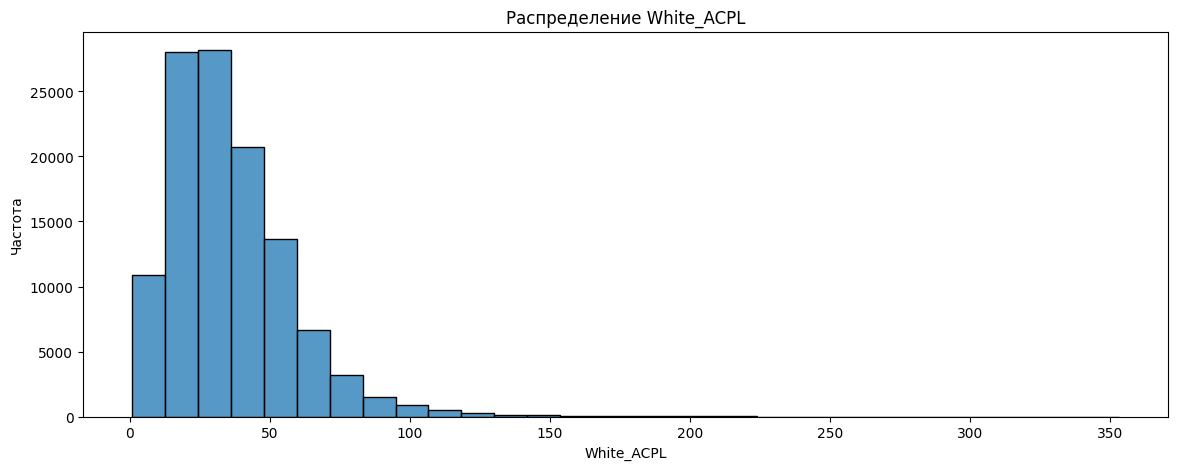

In [66]:
plt.figure(figsize=(14, 5))
sns.histplot(df['White_ACPL'], bins=30)
plt.title('Распределение White_ACPL')
plt.xlabel('White_ACPL')
plt.ylabel('Частота')
plt.show()

Распределение имеет положительную асимметрию (хвост уходит вправо), поэтому применим логарифмирование для уменьшения разброса значений и приведения данных к более нормальному виду.

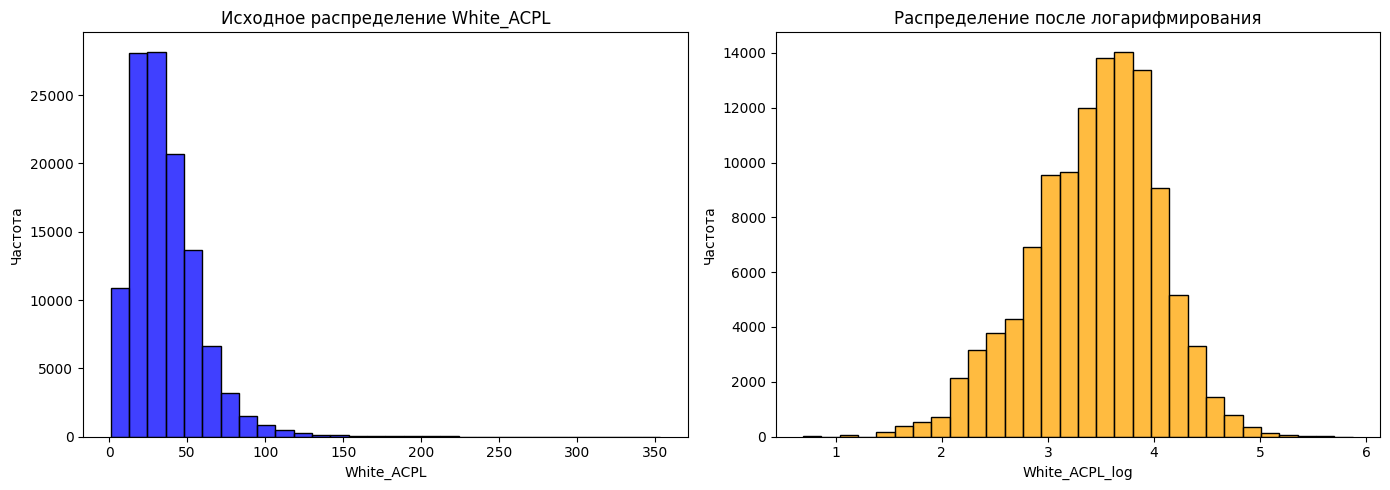

In [67]:
# Логарифмируем
df['White_ACPL_log'] = np.log1p(df['White_ACPL'])

# Строим график
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(df['White_ACPL'],
             bins=30, ax=ax[0], color="blue")
ax[0].set_title("Исходное распределение White_ACPL")
ax[0].set_xlabel("White_ACPL")
ax[0].set_ylabel("Частота")

sns.histplot(
    df['White_ACPL_log'], bins=30, ax=ax[1], color="orange")
ax[1].set_title("Распределение после логарифмирования")
ax[1].set_xlabel("White_ACPL_log")
ax[1].set_ylabel("Частота")

plt.tight_layout()
plt.show()

#### Параметр `Black_ACPL`

Black_ACPL - средний потерянный центильпешечный эквивалент (средняя ошибка по оценке движка) - числовой

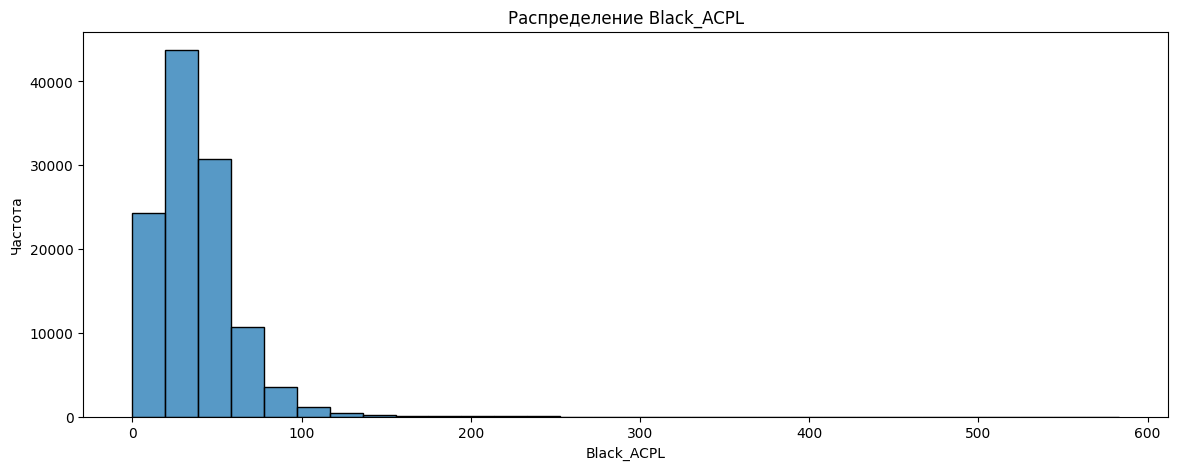

In [68]:
plt.figure(figsize=(14, 5))
sns.histplot(df['Black_ACPL'], bins=30)
plt.title('Распределение Black_ACPL')
plt.xlabel('Black_ACPL')
plt.ylabel('Частота')
plt.show()

Повторим действия, как для White_ACPL

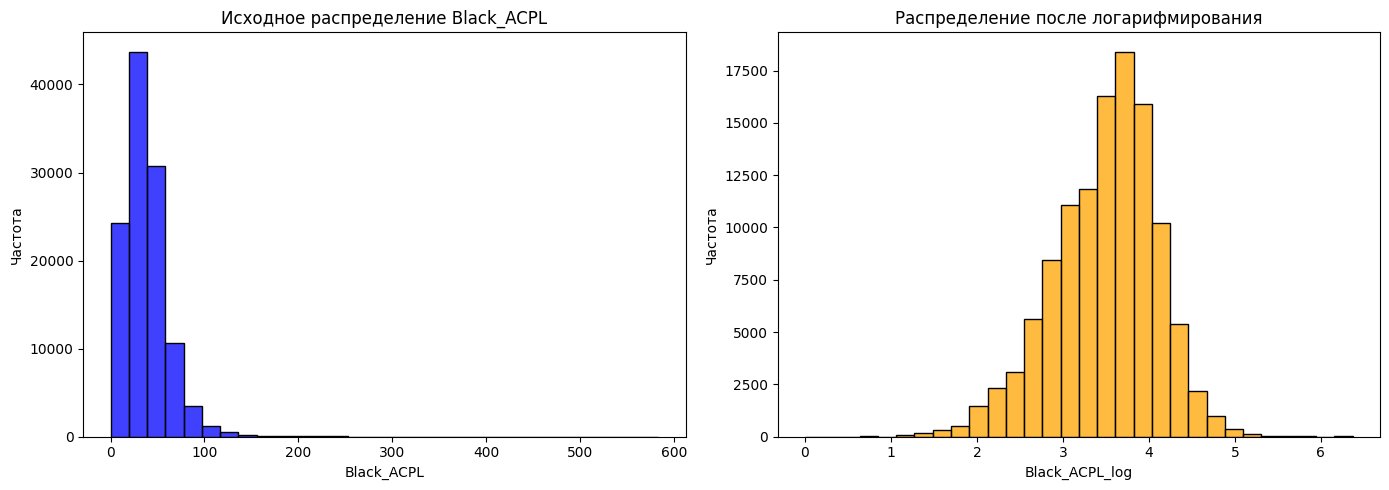

In [69]:
# Логарифмируем
df['Black_ACPL_log'] = np.log1p(df['Black_ACPL'])

# Строим график
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(df['Black_ACPL'],
             bins=30, ax=ax[0], color="blue")
ax[0].set_title("Исходное распределение Black_ACPL")
ax[0].set_xlabel("Black_ACPL")
ax[0].set_ylabel("Частота")

sns.histplot(
    df['Black_ACPL_log'], bins=30, ax=ax[1], color="orange")
ax[1].set_title("Распределение после логарифмирования")
ax[1].set_xlabel("Black_ACPL_log")
ax[1].set_ylabel("Частота")

plt.tight_layout()
plt.show()

#### Параметр `Clocks`

Clocks - информация о времени игроков по ходу партии в виде последовательного числового списка - категориальный

##### Новый параметр `White_Clocks` и `White_Clocks_Diffs`

Выделим отдельным параметром остаток времени на таймере игрока белыми фигруами после каждого хода

In [70]:
df['White_Clocks'] = df['Clocks'].apply(lambda x: x[::2])

Посчитаем затрачиваемое время на каждый ход игрока белыми фигурами

In [71]:
def calculate_time_spent_with_increment(clock_list, increment):
    clocks_sec = [x / 100 for x in clock_list]
    spent = []
    for i in range(1, len(clocks_sec)):
        time_used = clocks_sec[i - 1] - clocks_sec[i] + increment
        spent.append(round(max(time_used, 0), 2))
    return spent


df['White_Clocks_Diffs'] = df.apply(lambda row: calculate_time_spent_with_increment(
    row['White_Clocks'], row['Total_Time_Increment']), axis=1)

In [72]:
df['White_Q50'] = df['White_Clocks_Diffs'].apply(
    lambda x: np.quantile(x, 0.5).round(2))
df['White_Q75'] = df['White_Clocks_Diffs'].apply(
    lambda x: np.quantile(x, 0.75).round(2))
df['White_Q90'] = df['White_Clocks_Diffs'].apply(
    lambda x: np.quantile(x, 0.9).round(2))

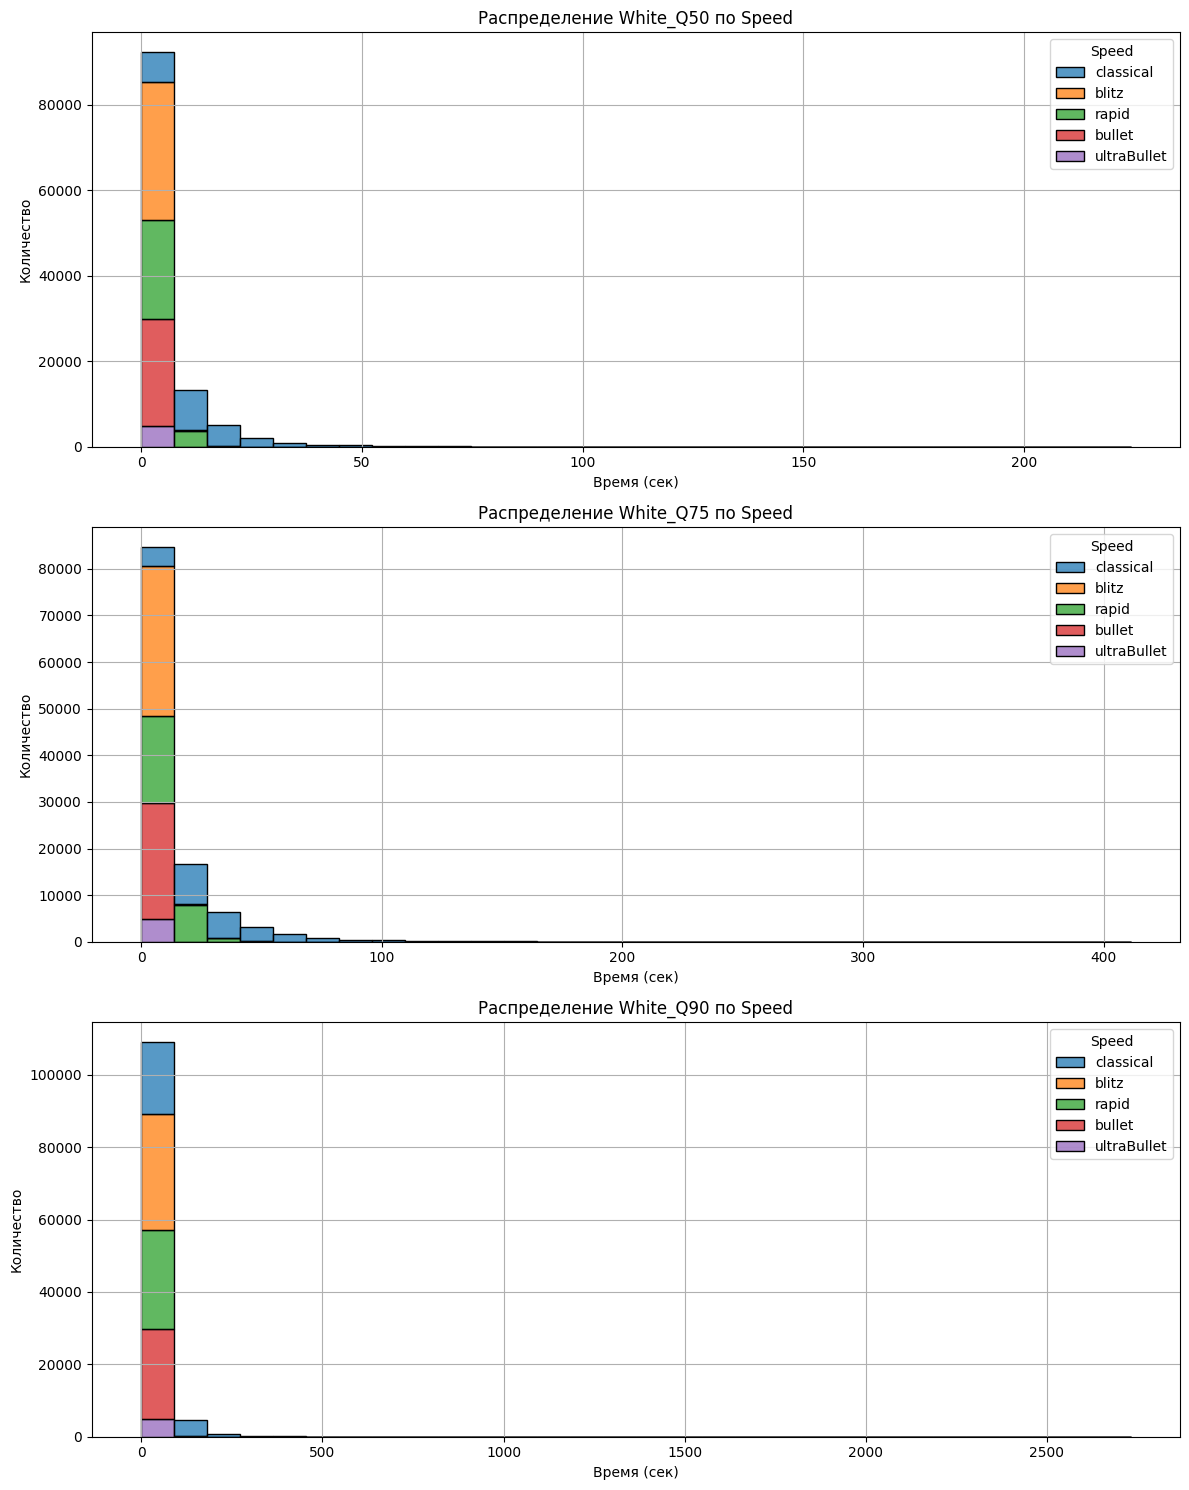

In [73]:
fig, axes = plt.subplots(3, 1, figsize=(12, 15))

sns.histplot(data=df, x='White_Q50', hue='Speed', bins=30,
              multiple='stack', ax=axes[0])
axes[0].set_title('Распределение White_Q50 по Speed')

sns.histplot(data=df, x='White_Q75', hue='Speed', bins=30,
              multiple='stack', ax=axes[1])
axes[1].set_title('Распределение White_Q75 по Speed')

sns.histplot(data=df, x='White_Q90', hue='Speed', bins=30,
              multiple='stack', ax=axes[2])
axes[2].set_title('Распределение White_Q90 по Speed')

for ax in axes:
    ax.set_xlabel('Время (сек)')
    ax.set_ylabel('Количество')
    ax.grid(True)

plt.tight_layout()
plt.show()

In [74]:
# TODO: МОжно прологарифмировать!

##### Новый параметр `Black_Clocks` и `Black_Clocks_Diffs`

In [75]:
df['Black_Clocks'] = df['Clocks'].apply(lambda x: x[1::2])

In [76]:
df['Black_Clocks_Diffs'] = df.apply(lambda row: calculate_time_spent_with_increment(
    row['Black_Clocks'], row['Total_Time_Increment']), axis=1)

In [77]:
df['Black_Q50'] = df['Black_Clocks_Diffs'].apply(
    lambda x: np.quantile(x, 0.5).round(2))
df['Black_Q75'] = df['Black_Clocks_Diffs'].apply(
    lambda x: np.quantile(x, 0.75).round(2))
df['Black_Q90'] = df['Black_Clocks_Diffs'].apply(
    lambda x: np.quantile(x, 0.9).round(2))

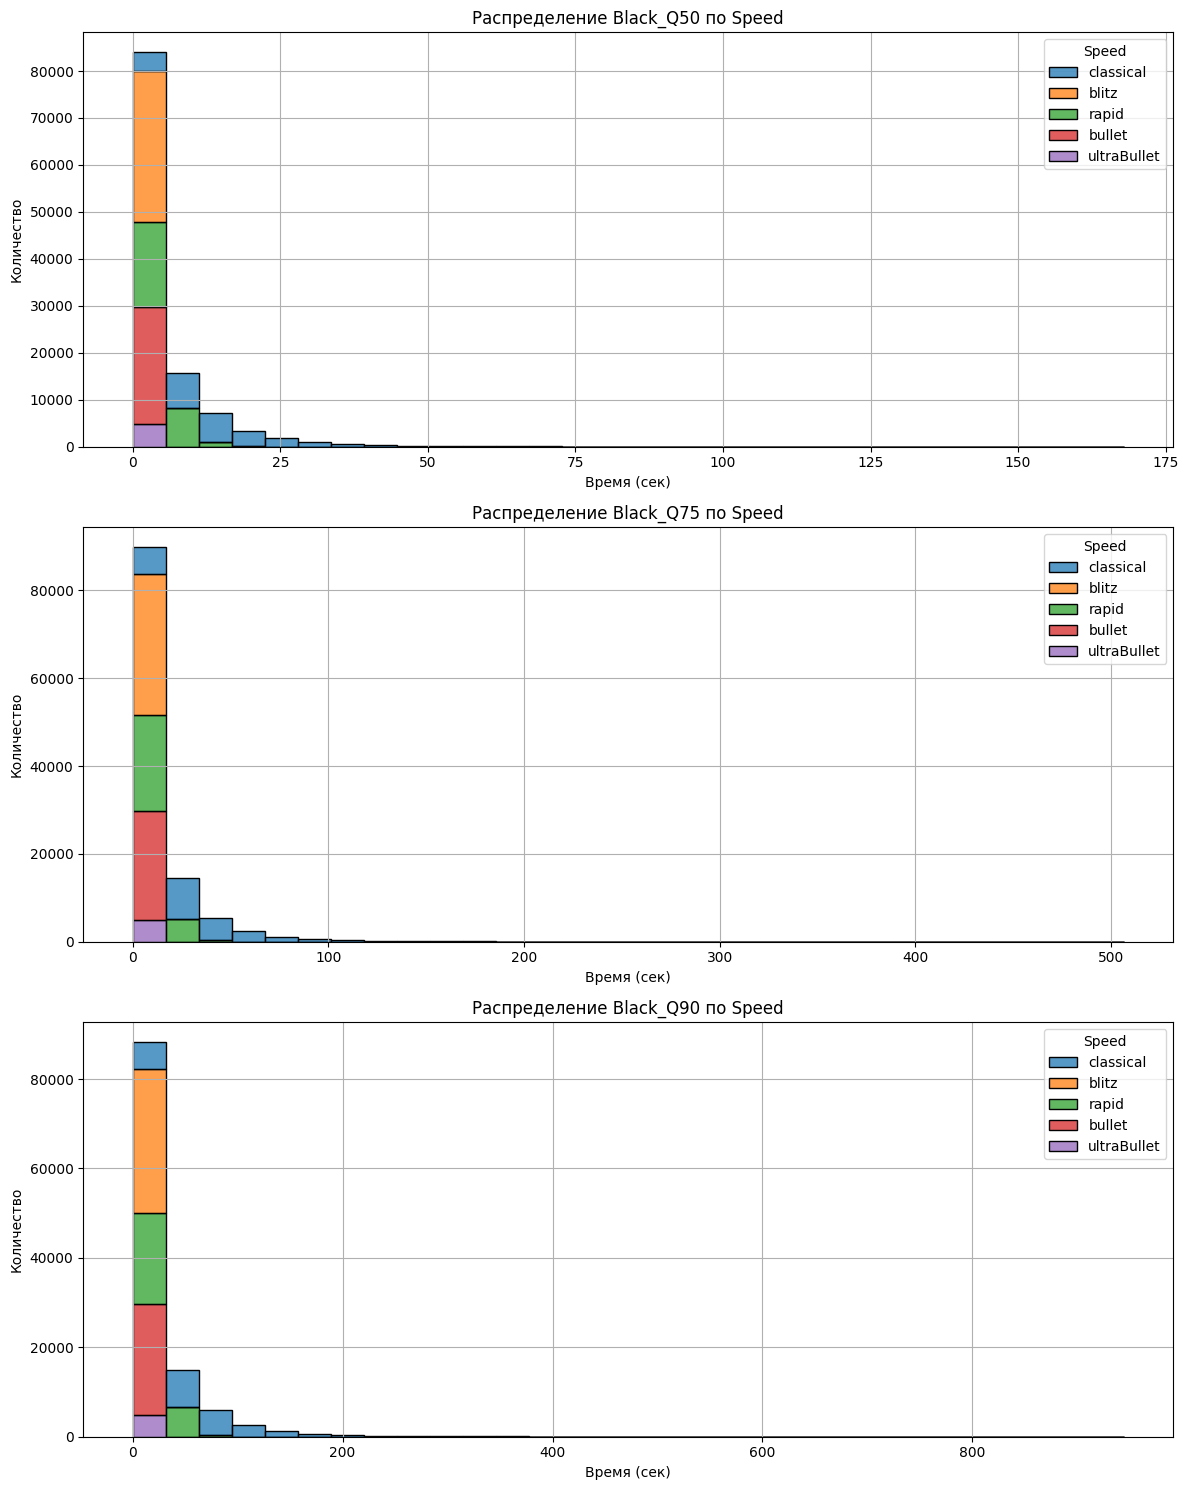

In [78]:
fig, axes = plt.subplots(3, 1, figsize=(12, 15))

sns.histplot(data=df, x='Black_Q50', hue='Speed', bins=30,
             multiple='stack', ax=axes[0])
axes[0].set_title('Распределение Black_Q50 по Speed')

sns.histplot(data=df, x='Black_Q75', hue='Speed', bins=30,
             multiple='stack', ax=axes[1])
axes[1].set_title('Распределение Black_Q75 по Speed')

sns.histplot(data=df, x='Black_Q90', hue='Speed', bins=30,
             multiple='stack', ax=axes[2])
axes[2].set_title('Распределение Black_Q90 по Speed')

for ax in axes:
    ax.set_xlabel('Время (сек)')
    ax.set_ylabel('Количество')
    ax.grid(True)

plt.tight_layout()
plt.show()

In [79]:
# TODO: можно прологарифмировать

#### Параметр `Analysis`

Analysis - данные анализа партии от Lichess движка - категориальный

в этом столбце хранятся данные по оценке позиций на шахматной доске, которую дает шахматный движок.
Число этих оценок зависит от хода игры.

eval — это числовое значение, которое показывает, насколько хороша или плоха текущая позиция для одного из игроков. 

Положительное значение: позиция выгодна для белых.
Отрицательное значение: позиция выгодна для черных.
Ноль: позиция сбалансирована, ни одна сторона не имеет явного преимущества.

Найдем среднее значение eval для каждой партии 

In [80]:
# Проверка типа данных столбца Analysis
type(df['Analysis'].iloc[0])

str

In [81]:
# Так как тип данных столбца Analysis строка, то необходимо преобразование строки в списки.
df['Analysis'] = df['Analysis'].apply(ast.literal_eval)

In [82]:
# Извлекаем значения eval из каждого словаря в списке с проверкой наличия ключа
def extract_eval(x):
    return [item['eval'] for item in x if 'eval' in item]

df['eval'] = df['Analysis'].apply(extract_eval)

# Найдем среднее значение eval для каждого элемента
df['avg_eval'] = df['eval'].apply(lambda x: sum(x) / len(x) if x else None)

In [83]:
avg_eval_column = df['avg_eval']
print(avg_eval_column)

0         186.257576
1         133.000000
2         -45.324324
3         110.714286
4         -21.457143
             ...    
114953    259.407407
114954    855.061224
114955    866.368421
114956   -342.734694
114957   -649.375000
Name: avg_eval, Length: 114958, dtype: float64


Найдем проценты партий, с приемущественными позициями белых и черных игроков.

In [84]:
# Общее количество партий
total_games = len(df)

# Подсчет партий в каждой категории
white_advantage = len(df[df['avg_eval'] > 0])
black_advantage = len(df[df['avg_eval'] < 0])
balanced_positions = len(df[df['avg_eval'] == 0])

# Вычисление процентов
white_advantage_percent = (white_advantage / total_games) * 100
black_advantage_percent = (black_advantage / total_games) * 100
balanced_positions_percent = (balanced_positions / total_games) * 100

# Вывод результатов
print(f"Процент партий, где преимущественно была выгодная позиция для белых: {white_advantage_percent:.2f}%")
print(f"Процент партий, где преимущественно была выгодная позиция для черных: {black_advantage_percent:.2f}%")
print(f"Процент сбалансированных позиций: {balanced_positions_percent:.2f}%")


Процент партий, где преимущественно была выгодная позиция для белых: 55.72%
Процент партий, где преимущественно была выгодная позиция для черных: 44.27%
Процент сбалансированных позиций: 0.00%


Найдем процент партий, где выиграли белые, несмотря на то, что средняя оценка позиции (avg_eval) была в пользу черных,
и наоборот, процент партий, где выиграли черные, несмотря на приемущество белых.

In [85]:
# Фильтрация партий, где белые выиграли, несмотря на преимущество черных
white_wins_black_advantage = df.query("Winner == 'white' and avg_eval < 0")

# Фильтрация партий, где черные выиграли, несмотря на преимущество белых
black_wins_white_advantage = df.query("Winner == 'black' and avg_eval > 0")

# Число партий, где игроку получилось резко развернуть ход игры в свою пользу, несмотря на приемущество противника в ходе игры.
result = pd.concat([white_wins_black_advantage, black_wins_white_advantage], ignore_index=True)

# Общее количество партий
total_games = len(df)

# Количество партий, соответствующих критериям
count_result = len(result)

percentage = count_result / total_games * 100

percentage = round(percentage, 0)

print("Общее количество партий:", total_games)
print("Количество партий, где белые выиграли с преимуществом черных или черные выиграли с преимуществом белых:", count_result)
print(f"Процент таких партий в общем объеме: {percentage:.2f} %")  # Используем f-строку для форматирования

Общее количество партий: 114958
Количество партий, где белые выиграли с преимуществом черных или черные выиграли с преимуществом белых: 13092
Процент таких партий в общем объеме: 11.00 %


Посчитаем количество оценок Lichess движка для каждой партии.

In [86]:
# Подсчет количества оценок в каждом списке
df['eval_count'] = df['eval'].apply(len)

# Группировка по Speed и вычисление среднего количества оценок
average_eval_count = df.groupby('Speed')['eval_count'].mean().reset_index(name='average_count')

# Выводим результат
print("\nСреднее количество оценок для каждой разновидности Speed:")
print(average_eval_count)


Среднее количество оценок для каждой разновидности Speed:
         Speed  average_count
0        blitz      82.339740
1       bullet      78.058684
2    classical      74.385033
3        rapid      79.693344
4  ultraBullet      61.943226


Сравним как распределяются значений eval в партиях с наибольшим и наименьшим числом ошибок.

In [87]:
df['Total_Mistakes'] = df['White_Mistake'] + df['Black_Mistake']

In [88]:
distribution_eval = df[['Total_Mistakes','eval']]

In [89]:
distribution_eval = distribution_eval.sort_values("Total_Mistakes", ascending=False)
distribution_eval

,Total_Mistakes,eval
106289,10,"[15, 25, 24, 27, 18, 22, 17, 14, 9, 13, 7, 15,..."
110303,10,"[18, 52, 53, 57, -93, -100, -183, -147, -144, ..."
108766,10,"[17, 44, 27, 50, 28, 66, 6, 3, 0, 0, 3, 5, -12..."
33440,10,"[17, 17, 17, 11, 17, 17, 4, 10, -39, -43, -43,..."
88460,10,"[17, 43, 27, 49, 53, 50, 15, 11, -12, -4, -201..."
...,...,...
91766,0,"[15, 21, 13, 19, 21, 25, 15, 28, 0, 12, 14, 9,..."
91764,0,"[16, 17, 17, 49, 46, 96, 67, 89, 90, 96, 85, 1..."
91758,0,"[16, 17, 17, 25, 21, 51, 56, 51, 53, 51, 42, 5..."
91756,0,"[15, 34, 46, 50, 40, 44, 48, 44, 44, 42, 45, 4..."


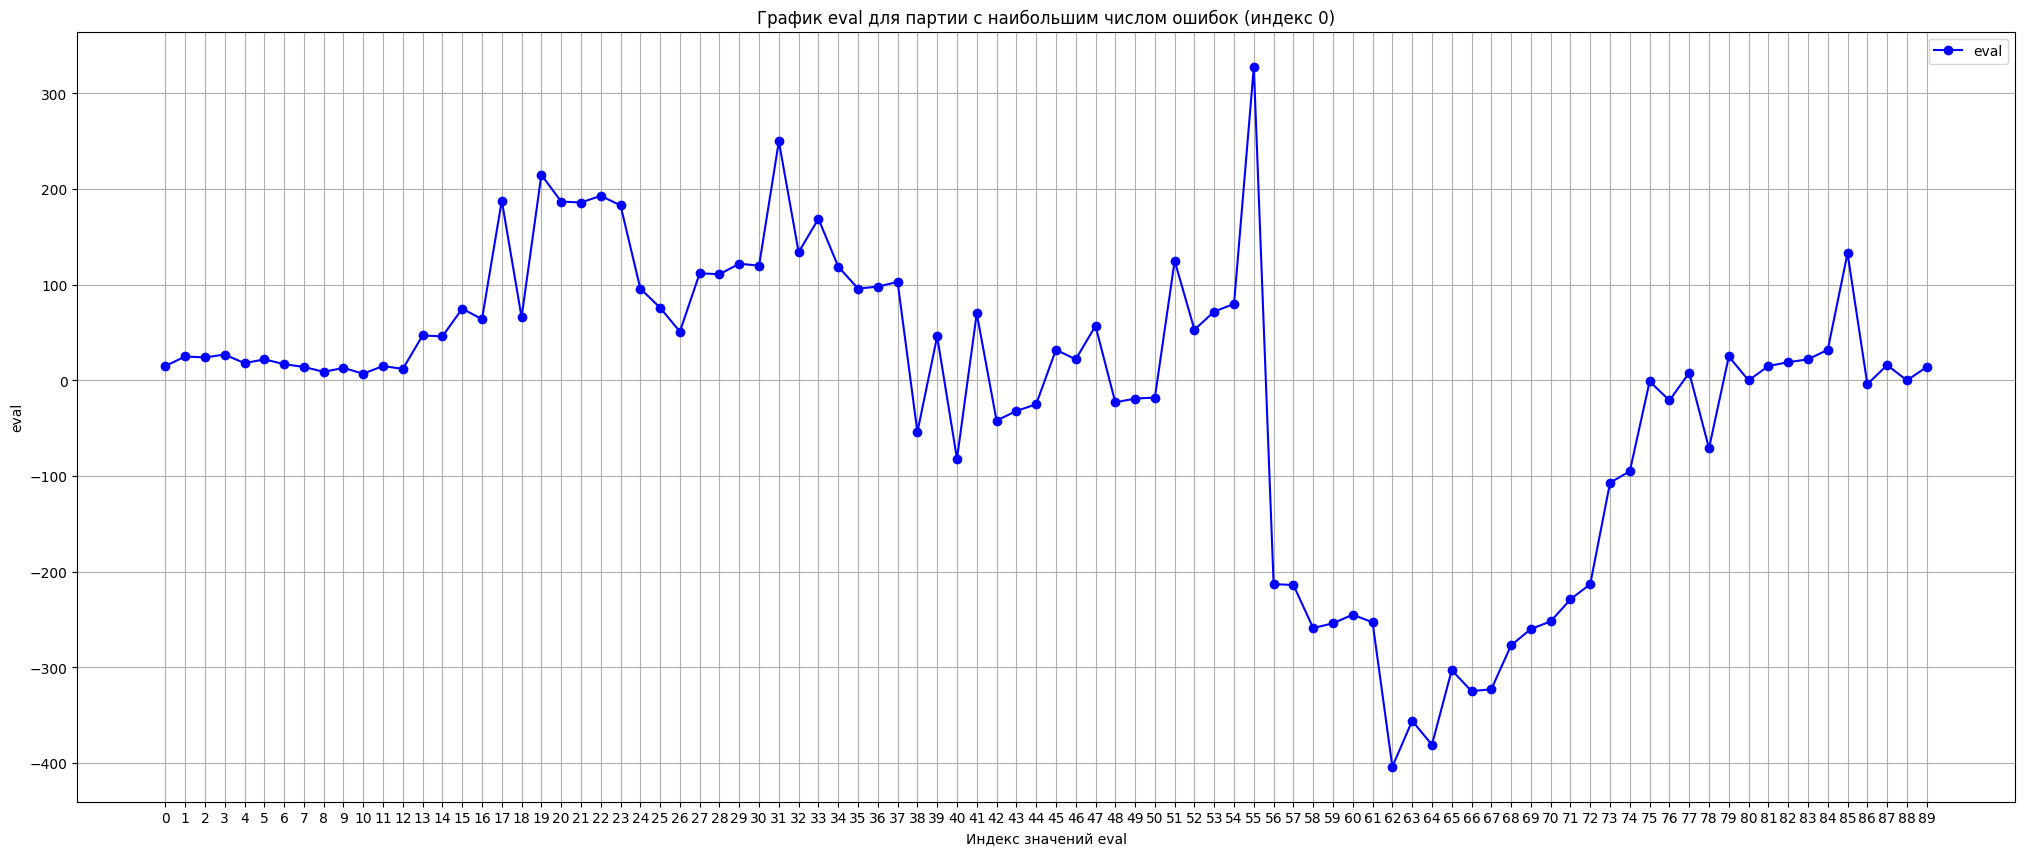

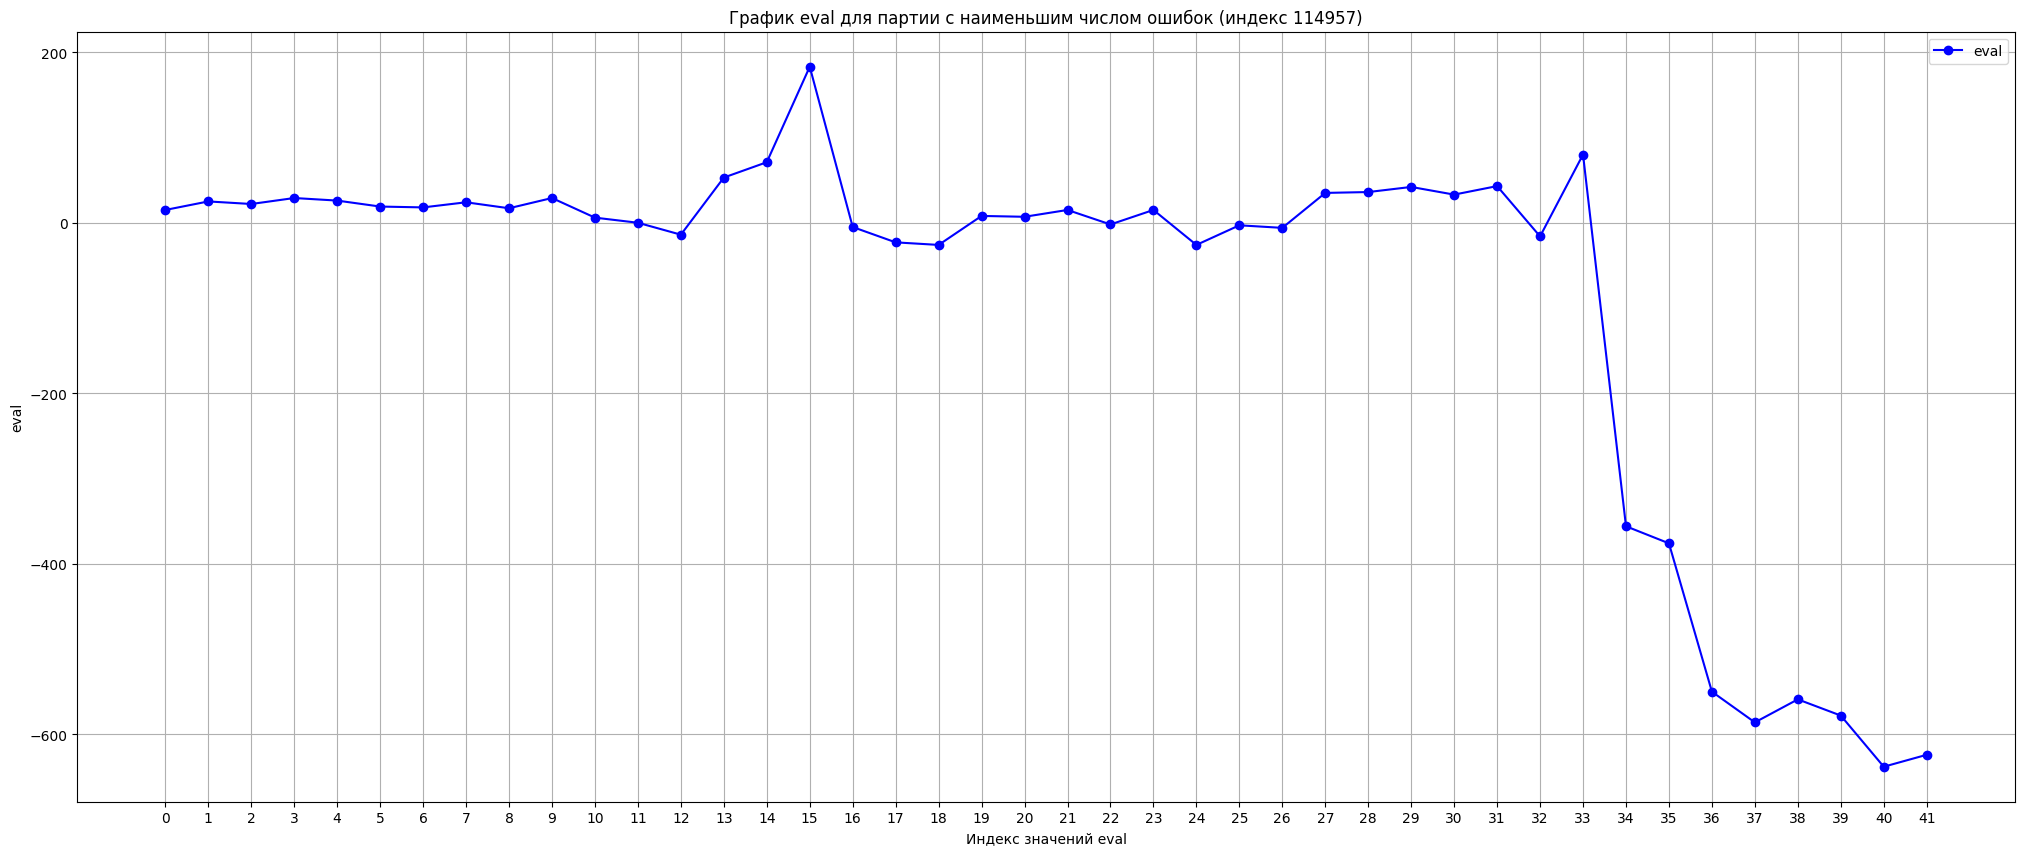

In [90]:
# Выбираем первую строку
row_index = 0  # Индекс первой строки
eval_values = distribution_eval['eval'].iloc[row_index]

# Создаем массив индексов для значений eval
index_values = list(range(len(eval_values)))

# Построение графика
plt.figure(figsize=(25, 10))
plt.plot(index_values, eval_values, marker='o', color='blue', label='eval')
plt.title(f'График eval для партии с наибольшим числом ошибок (индекс {row_index})')
plt.xlabel('Индекс значений eval')
plt.ylabel('eval')
plt.xticks(index_values)  # Устанавливаем метки по оси X
plt.grid()
plt.legend()
plt.show()

# Выбираем последнюю строку
row_index = len(distribution_eval) - 1  # Индекс последней строки
eval_values = distribution_eval['eval'].iloc[row_index]

# Создаем массив индексов для значений eval
index_values = list(range(len(eval_values)))

# Построение графика
plt.figure(figsize=(25, 10))
plt.plot(index_values, eval_values, marker='o', color='blue', label='eval')
plt.title(f'График eval для партии с наименьшим числом ошибок (индекс {row_index})')
plt.xlabel('Индекс значений eval')
plt.ylabel('eval')
plt.xticks(index_values)  # Устанавливаем метки по оси X
plt.grid()
plt.legend()
plt.show()

Вывод: Таким образом, мы прослеживаем закономерность между количеством ошибок и неоднородностью графика eval.
Чем больше ошибок, тем более неоднароден график eval, тем более резкие перепады между приемуществами белых и черных.

#### Параметр `Total_Time_Init`

Total_Time_Init - начальное время на партию в секундах - числовой

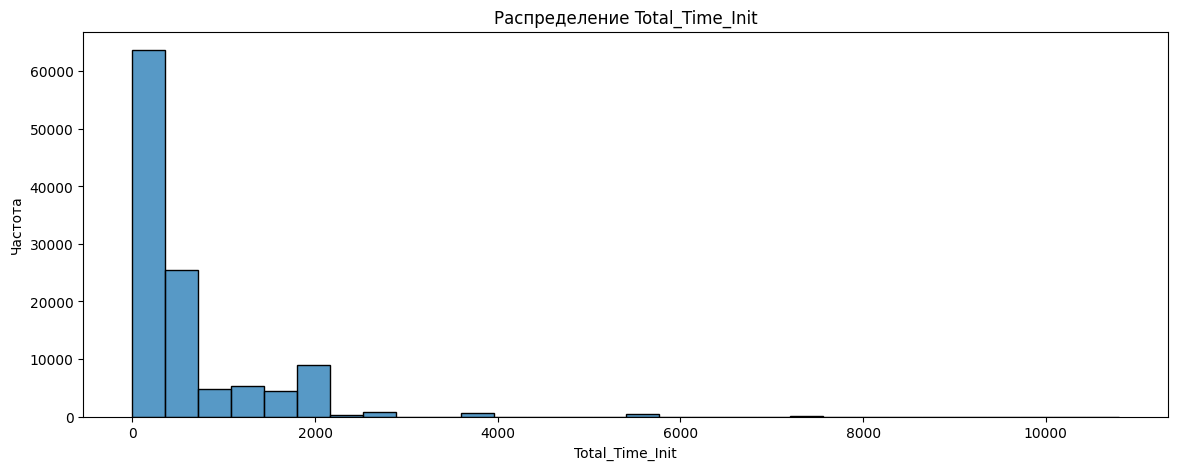

In [91]:
plt.figure(figsize=(14, 5))
sns.histplot(df['Total_Time_Init'], bins=30)
plt.title('Распределение Total_Time_Init')
plt.xlabel('Total_Time_Init')
plt.ylabel('Частота')
plt.show()

Классические турниры по шахматам имеют стартовое время 60 минут и 90 минут в офлайне или менее. В онлайне партий с большим стартовым временем встречается очень редко, поэтому удалим все значения, что больше показателя в 2000 секунд и построим снова распределение

In [92]:
df = df[df['Total_Time_Init'] <= 2000].reset_index(drop=True)

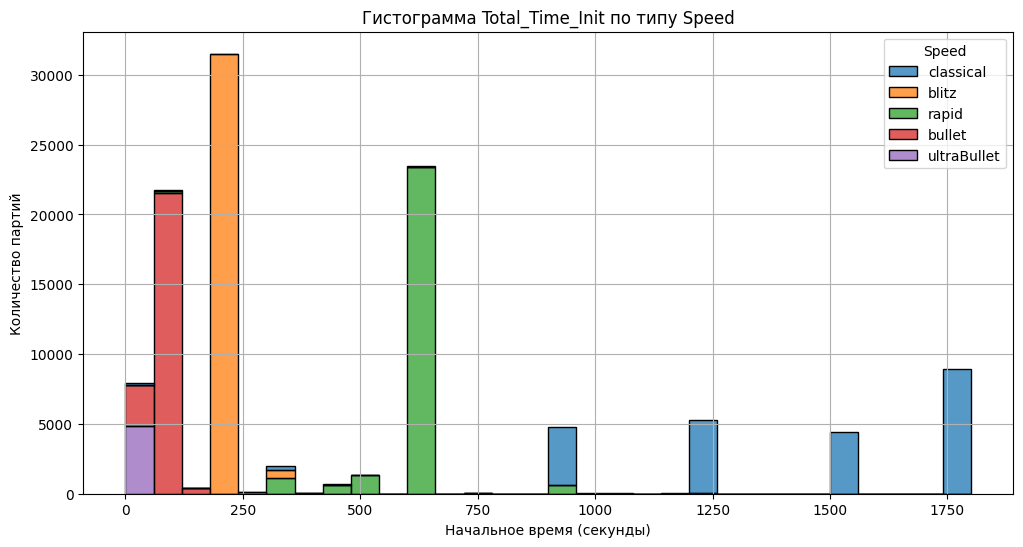

In [93]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='Total_Time_Init',
             hue='Speed', multiple='stack', bins=30)
plt.title('Гистограмма Total_Time_Init по типу Speed')
plt.xlabel('Начальное время (секунды)')
plt.ylabel('Количество партий')
plt.grid(True)
plt.show()

Мы видим, что распределение практически совпадает с группами параметра `Speed`

#### Параметр `Total_Time_Increment`

Total_Time_Increment - добавление времени за ход в секундах - числовой

Посмотрим на распределение параметра

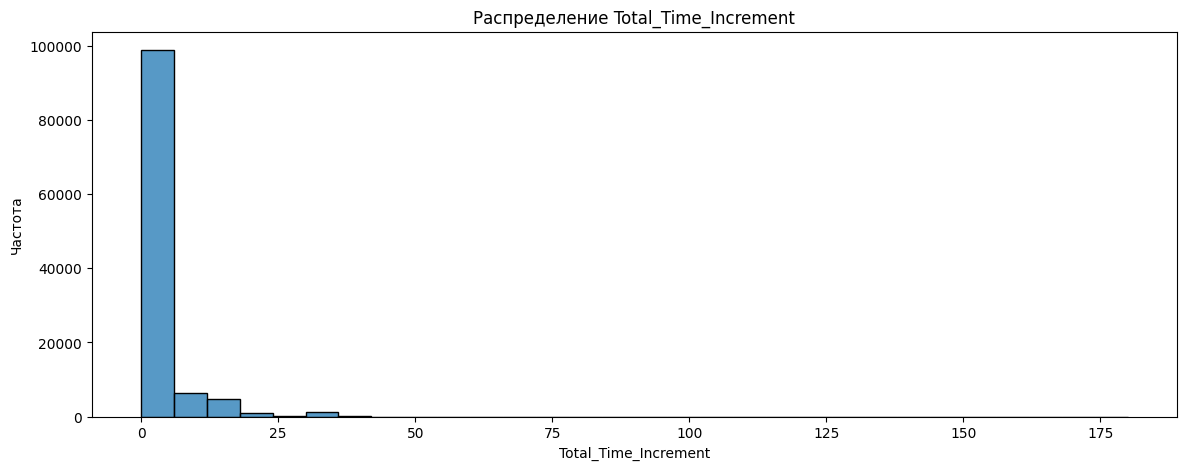

In [94]:
plt.figure(figsize=(14, 5))
sns.histplot(df['Total_Time_Increment'], bins=30)
plt.title('Распределение Total_Time_Increment')
plt.xlabel('Total_Time_Increment')
plt.ylabel('Частота')
plt.show()

Видим что имеется большое кол-во выбросов. 
На практике классическим добавлением на ход по регламенту FIDE яв-ся 30 секунд. Что мы и видим на графике. 
Все, что больше 30 секунд добавления яв-ся нестандартной игрой. Поэтому удалим эти значения и затем построим новый график

In [95]:
df = df[df['Total_Time_Increment'] <= 31].reset_index(drop=True)

Посмотрим снова на распределение

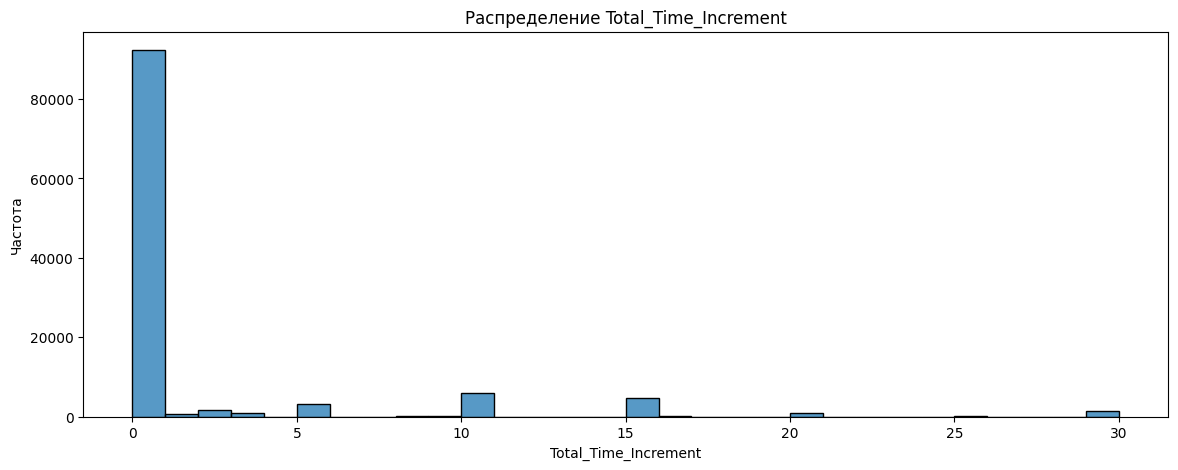

In [96]:
plt.figure(figsize=(14, 5))
sns.histplot(df['Total_Time_Increment'], bins=30)
plt.title('Распределение Total_Time_Increment')
plt.xlabel('Total_Time_Increment')
plt.ylabel('Частота')
plt.show()

Создадим категориальный параметр для объединения распределений по группам

In [97]:
def group_increment(x):
    if x == 0:
        return '0 sec'
    elif x <= 3:
        return '1–3 sec'
    elif x <= 10:
        return '4–8 sec'
    elif x <= 15:
        return '9–15 sec'
    else:
        return '15+ sec'


df['Total_Time_Increment_Group'] = df['Total_Time_Increment'].apply(
    group_increment)

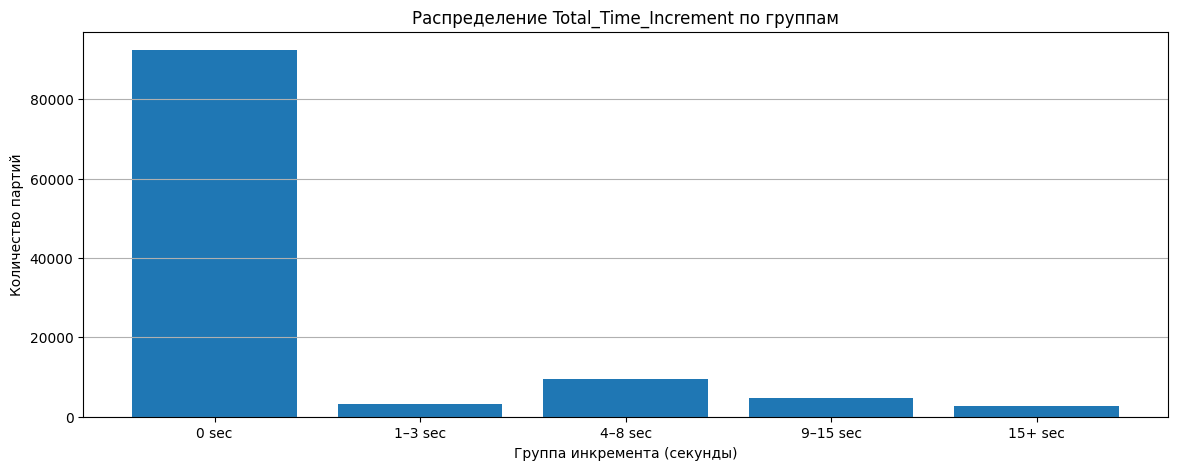

In [98]:
ordered_groups = ['0 sec', '1–3 sec', '4–8 sec', '9–15 sec', '15+ sec']

group_counts = df['Total_Time_Increment_Group'].value_counts().reindex(
    ordered_groups)

plt.figure(figsize=(14, 5))
plt.bar(group_counts.index, group_counts.values)
plt.title("Распределение Total_Time_Increment по группам")
plt.xlabel("Группа инкремента (секунды)")
plt.ylabel("Количество партий")
plt.grid(axis='y')
plt.show()

#### Параметр `Total_Time`

Total_Time - общее затраченное время на партию - числовой

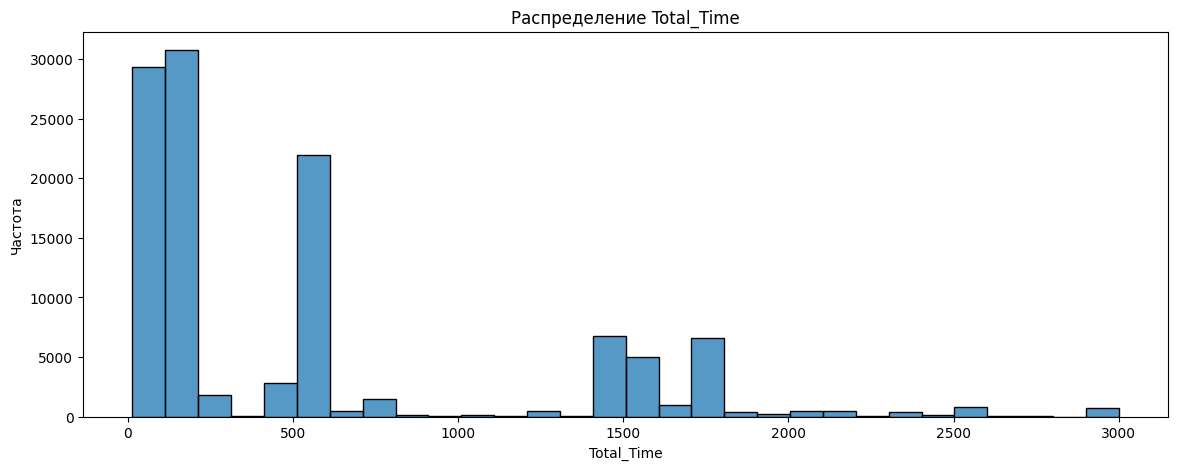

In [99]:
plt.figure(figsize=(14, 5))
sns.histplot(df['Total_Time'], bins=30)
plt.title('Распределение Total_Time')
plt.xlabel('Total_Time')
plt.ylabel('Частота')
plt.show()

In [100]:
# TODO: что делать с этим?
# Кажется, что этот столбец нужно дропнуть. Он не совпадает ни с Game_Duration, ни

In [101]:
# df[df['Total_Time_Increment'] > 0][['Num_Moves', 'Total_Time_Increment', 'Total_Time_Init', 'Total_Time', 'Game_Duration']]

#### Параметр `Moves`

Moves - список ходов, сделанных в партии - категориальный

Посмотрим какие самые популярные начальные ходы делаются в партиях.

In [102]:
df["Moves"].apply(lambda x: x.split()[:6]).value_counts()

Moves
[e4, c5, Nf3, d6, d4, cxd4]        3969
[e4, e5, Nf3, Nc6, Bb5, a6]        2075
[e4, c5, Nf3, e6, d4, cxd4]        1936
[d4, Nf6, c4, e6, Nc3, Bb4]        1671
[e4, c5, Nf3, Nc6, d4, cxd4]       1652
                                   ... 
[e4, d5, Nc3, dxe4, Bc4, Nf6]         1
[e4, d5, Bc4, dxe4, Bb3, e6]          1
[e4, d5, Nc3, Nf6, Nf3, d4]           1
[e4, Nf6, Nc3, Nxe4, Nf3, Nxf2]       1
[h4, c5, e3, Nc6, Nc3, Nf6]           1
Name: count, Length: 17651, dtype: int64

Посмотрим какой фигурой чаще всего делается последний ход

In [103]:
df["Moves"].apply(lambda x: "P" if x.split()[-1][0].islower() else x.split()
                           [-1][0] if x.split()[-1][0] != "O" else "Castle").value_counts()

Moves
Q         30121
R         26632
K         16606
P         15201
B         12050
N         11765
Castle      106
Name: count, dtype: int64

Чаще всего завершает игру ход Ферзем или ладьей

#### Новый параметр `Is_Berserk_White` и `Is_Berserk_Black`

Создадим параметр, показывающий брал ли игрок белыми и черными берсерк режим на партию

In [104]:
df['Is_Berserk_White'] = df.apply(
    lambda row: row['White_Clocks'][0] < (row['Total_Time_Init'] * 100) / 1.5,
    axis=1
)

In [105]:
berserk_counts_white = df['Is_Berserk_White'].value_counts()
berserk_white_percentages = df['Is_Berserk_White'].value_counts(
    normalize=True) * 100

berserk_summary_white = pd.DataFrame({
    'Count': berserk_counts_white,
    'Percentage': berserk_white_percentages.round(2)
}).reset_index().rename(columns={'index': 'Is_Berserk_White'})
berserk_summary_white

,Is_Berserk_White,Count,Percentage
0,False,107366,95.45
1,True,5115,4.55


In [106]:
df['Is_Berserk_Black'] = df.apply(
    lambda row: row['Black_Clocks'][0] < (row['Total_Time_Init'] * 100) / 1.5,
    axis=1
)

In [107]:
berserk_counts = df['Is_Berserk_Black'].value_counts()
berserk_black_percentages = df['Is_Berserk_Black'].value_counts(normalize=True) * 100

berserk_summary_black = pd.DataFrame({
    'Count': berserk_counts,
    'Percentage': berserk_black_percentages.round(2)
}).reset_index().rename(columns={'index': 'Is_Berserk_Black'})
berserk_summary_black

,Is_Berserk_Black,Count,Percentage
0,False,107509,95.58
1,True,4972,4.42


Посмотрим в каком кол-ве партий оба игрока брали берсерк режим

In [108]:
both_berserk = df[(df['Is_Berserk_White']) & (df['Is_Berserk_Black'])]

count_both_berserk = both_berserk.shape[0]

percentage_both_berserk = (count_both_berserk / df.shape[0]) * 100

print(f"Количество партий, где оба игрока взяли берсерк: {count_both_berserk}")
print(f"Процент таких партий: {percentage_both_berserk:.2f}%")

Количество партий, где оба игрока взяли берсерк: 2744
Процент таких партий: 2.44%


#### Новый параметр `Game_Duration`

Создадим на основе параметров `Created_At` и `Last_Move_At` параметр - продолжительность партии

In [109]:
df['Game_Duration'] = (df['Last_Move_At'] - df['Created_At']).dt.total_seconds()

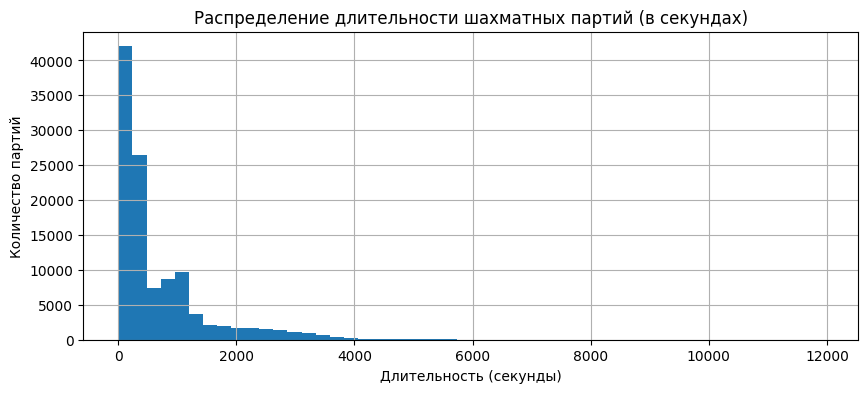

In [110]:
plt.figure(figsize=(10, 4))
plt.hist(df['Game_Duration'], bins=50)
plt.title('Распределение длительности шахматных партий (в секундах)')
plt.xlabel('Длительность (секунды)')
plt.ylabel('Количество партий')
plt.grid(True)
plt.show()

In [111]:
# TODO: Удаляем выбросы?
# TODO: Сравнить с Total_Time

#### Новый параметр `Num_Moves`

На основе параметра Moves - список ходов, сделанных в партии - категориальный.
Создадим новый параметр кол-во ходов в партии

In [112]:
df["Num_Moves"] = df["Moves"].apply(
    lambda x: len(x.split()) // 2)

Посмотрим на распределение параметра и описательную статистику

In [113]:
df["Num_Moves"].describe()

count    112481.000000
mean         40.784319
std          17.670172
min           2.000000
25%          28.000000
50%          38.000000
75%          51.000000
max         229.000000
Name: Num_Moves, dtype: float64

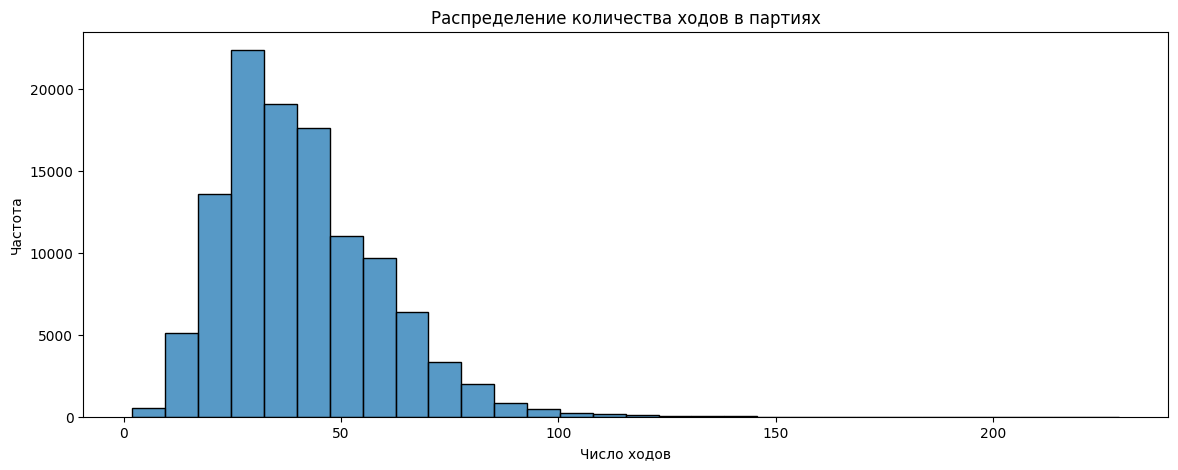

In [114]:
plt.figure(figsize=(14, 5))
sns.histplot(df["Num_Moves"], bins=30)
plt.title("Распределение количества ходов в партиях")
plt.xlabel("Число ходов")
plt.ylabel("Частота")
plt.show()

## Описательная статистика

In [115]:
df.describe()

,Created_At,Last_Move_At,Opening_PLY,White_Rating,White_Inaccuracy,White_Mistake,White_Blunder,White_ACPL,Black_Rating,Black_Inaccuracy,...,White_Q75,White_Q90,Black_Q50,Black_Q75,Black_Q90,avg_eval,eval_count,Total_Mistakes,Game_Duration,Num_Moves
count,112481,112481,112481.000000,112481.000000,112481.000000,112481.000000,112481.000000,112481.000000,112481.000000,112481.000000,...,112481.000000,112481.000000,112481.000000,112481.000000,112481.000000,112481.000000,112481.000000,112481.000000,112481.000000,112481.000000
mean,2024-06-08 08:55:50.797805312,2024-06-08 09:07:18.808065024,6.460789,2570.589255,2.830300,1.078902,1.367058,35.980121,2571.429317,2.860501,...,10.693889,21.272957,4.681949,10.927991,21.575450,24.581417,78.217708,2.171096,688.010260,40.784319
min,2020-01-01 00:21:47,2020-01-01 01:03:35,1.000000,1548.000000,0.000000,0.000000,0.000000,1.000000,1562.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.030000,-2835.864865,3.000000,0.000000,3.000000,2.000000
25%,2024-04-12 12:16:32,2024-04-12 12:18:20,3.000000,2326.000000,1.000000,0.000000,0.000000,20.000000,2329.000000,1.000000,...,1.680000,3.050000,0.960000,1.740000,3.130000,-111.578947,54.000000,1.000000,129.000000,28.000000
50%,2024-10-05 11:07:57,2024-10-05 11:15:11,6.000000,2606.000000,2.000000,1.000000,1.000000,32.000000,2604.000000,3.000000,...,4.780000,9.470000,2.080000,4.880000,9.680000,24.522388,73.000000,2.000000,342.000000,38.000000
75%,2024-12-27 16:22:56,2024-12-27 16:34:09,9.000000,2807.000000,4.000000,2.000000,2.000000,47.000000,2807.000000,4.000000,...,13.600000,27.490000,5.680000,14.000000,27.800000,165.111111,98.000000,3.000000,955.000000,51.000000
max,2025-02-05 08:53:27,2025-02-05 09:04:38,28.000000,3438.000000,17.000000,5.000000,5.000000,353.000000,3441.000000,17.000000,...,285.880000,631.200000,158.830000,297.610000,590.860000,2357.310000,300.000000,10.000000,11933.000000,229.000000
std,NaN,NaN,3.916134,326.958886,2.181783,1.169122,1.333580,21.664961,325.165054,2.164029,...,14.671638,29.103132,6.545845,14.980493,29.470359,228.648993,32.538437,1.874585,855.167839,17.670172


## Корреляционная матрица

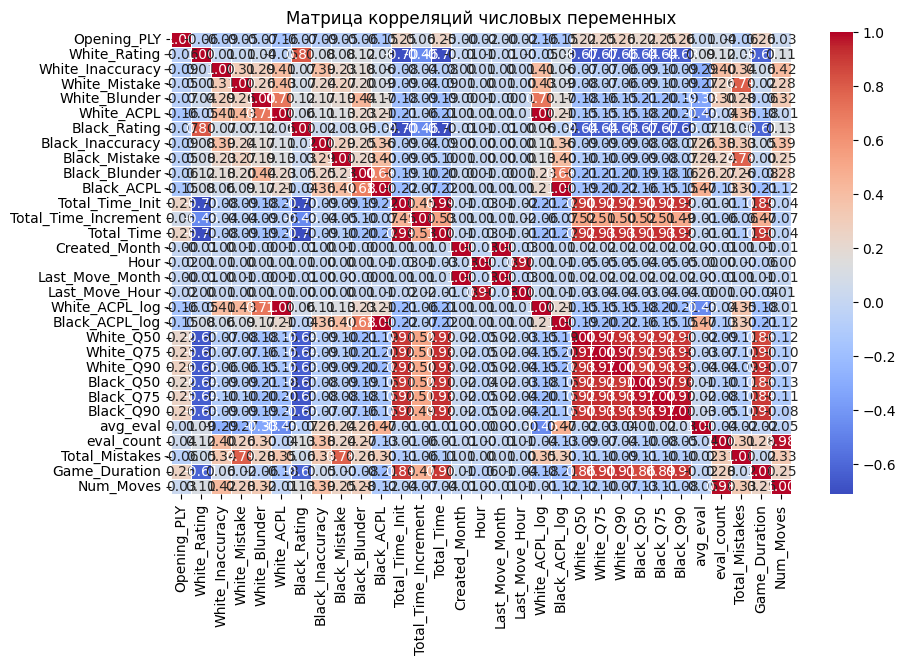

In [116]:
correlation_matrix = df.select_dtypes(include=[np.number]).corr(method='spearman')

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f",
            cmap="coolwarm", linewidths=0.5)
plt.title("Матрица корреляций числовых переменных")
plt.show()

In [117]:
# TODO: Добавить категориальные признаки

In [118]:
# TODO: Выводы по матрице

In [119]:
df.shape

(112481, 60)